<a href="https://colab.research.google.com/github/Joseph-Willem-Ricci/5450-final-project/blob/joe/CIS5450_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIT 5450 Final Project
Joanne Crean, Juan Goleniowski, Joseph Ricci

# Introduction/Background

Hi there! Welcome to Joe, Juan, and Joanne's CIS 545 final project from Spring 2023. 

We are curious about what makes a song a “hit”. Is it a certain quality of the music that makes a song popular? Or how famous an artist already is? Do lyrical themes play a role? Is virality on social media a major driver of success? 

We found Kaggle projects where teams have studied trends in the Spotify charts but we haven’t identified a study that goes further than audio features to look at the artist’s profile and the lyrical themes. We aim to predict whether a song will rank highly on the Spotify charts, and to show how much of the song’s success is explained by each feature.

We will apply some models to see if we can predict how popular a song is depending on various features, and along the way we will try to gain some insight into different trends, song similarity, and which features contribute the most to a song's success. We will take the song’s audio features, the artist’s previous success in the Spotify charts, TikTok popularity and the lyrics into account. 

The datasets that we are using are:
*  Spotify song rankings 2017-2021: https://www.kaggle.com/datasets/dhruvildave/spotify-charts
*  Spotify song audio features:
  - https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs
  - https://www.kaggle.com/rodolfofigueroa/spotify-12m-songs
  - https://www.kaggle.com/muhmores/spotify-top-100-songs-of-20152019
  - https://www.kaggle.com/sashankpillai/spotify-top-200-charts-20202021
  - https://www.kaggle.com/maharshipandya/-spotify-tracks-dataset
  - https://www.kaggle.com/vatsalmavani/spotify-dataset
  - https://www.kaggle.com/nandhakumarss/spotify-song-tracks
  - https://www.kaggle.com/elemento/music-albums-popularity-prediction
*  The most popular songs on Tiktok in 2019-2021
https://www.kaggle.com/datasets?search=tiktok+popular+songs
*  Lyrics - dataset we made ourselves from https://genius.com/, available at https://www.kaggle.com/datasets/joannecrean/spotify-songs-lyrics
*  Artist profile - features engineered from the Spotify dataset looking at the artist's success in the previous year.



# Setup

## Libraries and data 

In [1]:
# Installs
%%capture
!pip install -q kaggle
!pip install pandasql
!pip install sqlalchemy==1.4.46
!pip install translate
!pip install langdetect

In [2]:
# Imports
import pandas as pd
import pandasql as ps
from google.colab import drive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import euclidean_distances
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import gc
from sklearn.impute import KNNImputer
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from translate import Translator
from pandas.plotting import scatter_matrix
from langdetect import detect
from collections import Counter

In [3]:
# Setup
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
# Download Datasets
%%capture
# Spotify Top 200 and Viral 50 Charts for 2017 through 2021 Dataset
!!kaggle datasets download -d dhruvildave/spotify-charts

# Spotify Audio Features Datasets
!!kaggle datasets download -d rodolfofigueroa/spotify-12m-songs
!!kaggle datasets download -d muhmores/spotify-top-100-songs-of-20152019
!!kaggle datasets download -d sashankpillai/spotify-top-200-charts-20202021
!!kaggle datasets download -d maharshipandya/-spotify-tracks-dataset
!!kaggle datasets download -d vatsalmavani/spotify-dataset
!!kaggle datasets download -d nandhakumarss/spotify-song-tracks
!!kaggle datasets download -d elemento/music-albums-popularity-prediction

# TikTok Popular Songs Dataset
!!kaggle datasets download -d sveta151/tiktok-popular-songs-2019
!!kaggle datasets download -d sveta151/tiktok-popular-songs-2020
!!kaggle datasets download -d sveta151/tiktok-popular-songs-2021

In [5]:
# Unzip Datasets
%%capture
!unzip /content/spotify-charts.zip
!unzip /content/spotify-12m-songs.zip
!unzip /content/spotify-top-100-songs-of-20152019.zip
!unzip /content/spotify-top-200-charts-20202021.zip
!unzip /content/-spotify-tracks-dataset.zip
!unzip /content/spotify-dataset.zip
!unzip /content/spotify-song-tracks.zip
!unzip /content/music-albums-popularity-prediction.zip
!unzip /content/tiktok-popular-songs-2019
!unzip /content/tiktok-popular-songs-2020
!unzip /content/tiktok-popular-songs-2021

In [6]:
# Clean up directory to save space
%%capture
!rm sample_data/*
!rm -d sample_data
!rm ./*.zip
!rm sample_solution.csv
!rm ./*.xlsx

In [7]:
# Read the csv files and save them to pandas dataframes
df_charts = pd.read_csv('charts.csv')
df_song_features_1 = pd.read_csv('tracks_features.csv')
df_song_features_2 = pd.read_csv('Spotify 2010 - 2019 Top 100.csv')
df_song_features_3 = pd.read_csv('spotify_dataset.csv')
df_song_features_4 = pd.read_csv('dataset.csv')
df_song_features_5 = pd.read_csv('data/data.csv')
df_song_features_6 = pd.read_csv('SpotifyFeatures.csv')
df_song_features_7 = pd.read_csv('train.csv')  # contains three songs per row, expands to 8 and 9 below
df_song_features_10 = pd.read_csv('test.csv')  # contains three songs per row, expands to 11 and 12 below
df_tiktok_19 = pd.read_csv('TikTok_songs_2019.csv')
df_tiktok_20 = pd.read_csv('TikTok_songs_2020.csv')
df_tiktok_21 = pd.read_csv('TikTok_songs_2021.csv')

In [8]:
# Clean up remaining files
!rm data/*
!rm -d data
!rm ./*.csv

# Data wrangling and EDA

## Spotify Top 200 and Viral 50 Charts EDA

Lets take a quick look at the charts dataset to see what we are dealing with.

In [9]:
df_charts.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


Each row in `df_charts` is uniquely identified by a song title, artist, date (2017 through 2021), region. This entry then also contains chart rank for that region, url, type of chart (viral50 or top200), and stream count for that day in that country. This is to say that one song may appear up to 365 times per country. We will eventually be grouping this data set by year, title and artist, so that we have the maximum ranking for a given song in given year in all countries, but first, lets do some basic clean up so that the aggregation methods can run.

In [10]:
# Create a separate column for Year
df_charts['Year'] = df_charts['date'].str.extract(r'(\d{4})', expand=False)

# Cast 'Year' as Int
df_charts['Year'] = df_charts['Year'].astype(int)

#remove ID, trend and streams columns
df_charts.drop(['url', 'trend', 'streams'], axis=1, inplace=True)

#Remove NAn from dataset
df_charts.dropna(inplace=True)

# Show datatypes 
df_charts.dtypes

title     object
rank       int64
date      object
artist    object
region    object
chart     object
Year       int64
dtype: object

## Spotify Audio Feature Dataset Wrangling and EDA

Since the Spotify charts dataset does not come with audio features the songs, there is no guarantee that we can find datasets that include audio features for all of the songs in the charts. One of the first questions to address then is

1. Can we find audio feature data for a suitably large fraction of the songs in the Charts dataset?

Additionally, since we'll be combining multiple audio features datasets, there is no guarantee that those datasets share the same features, so

2. What fields do the datasets share?

There are many datasets available on kaggle that contain Spotify audio features, but not all are very usable, clean, large enough, for the same years, or containing a large enough set of features. So we started by searching on kaggle for as many data sets as we could find that seemed big, had high usability, many features, and that were at least not explicitly for songs released outside of 2017 - 2021.

We eventually settled on the following set of datasets for audio features, at which point we began wrangling, cleaning, and understanding how many songs in `charts_df` we could find matching features for.

In [11]:
# First, since we want to find song features for as many of the songs in 'df_charts' as possible, let's start by
# projecting df_charts by song title and artist name, which will uniquely identify each song, and then dropping duplicates.
# This will make it easier to do big joins with the songs in charts_df to see if we have matches
df_charts_songs_artists = df_charts[['title', 'artist']].drop_duplicates()

# We will omit the section where we visually inspected each of the 8 features data sets, but through this process we
# discovered that some columns were formatted differently in different datasets, i.e. if there were mutliple artists,
# some datasets listed them like "Portico Quartet, Hania Rani", and some listed them like ['Portico Quartet', 'Hania Rani']
# so below we clean extranneous characters from artist columns if necessary to arrive at a consistent format
df_song_features_1['artists'] = df_song_features_1['artists'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
df_song_features_5['artists'] = df_song_features_5['artists'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
df_song_features_7['artists'] = df_song_features_7['artists'].str.replace(', ', '')
df_song_features_10['artists'] = df_song_features_10['artists'].str.replace(', ', '')

In [12]:
# Rename song title "title" and "artist" columns in each dataframe and 
# create separate dataframes for features_7 and features_10, which each have three columns for each field for three different songs
df_song_features_1 = df_song_features_1.rename(columns={'name': 'title', 'artists': 'artist'})
# _song_features_2 already has fields 'title' and 'artist'
df_song_features_3 = df_song_features_3.rename(columns={'Song Name': 'title', 'Artist': 'artist'})
df_song_features_4 = df_song_features_4.rename(columns={'track_name': 'title', 'artists': 'artist'})
df_song_features_5 = df_song_features_5.rename(columns={'name': 'title', 'artists': 'artist'})
df_song_features_6 = df_song_features_6.rename(columns={'track_name': 'title', 'artist_name': 'artist'})
df_song_features_8 = df_song_features_7.rename(columns={'t_name1': 'title', 'artists': 'artist'}).drop(columns=['t_name0', 't_name2', 't_dur0', 't_dur2', 't_dance0', 't_dance2', 't_energy0', 't_energy2', 't_key0', 't_key2', 't_mode0', 't_mode2', 't_speech0', 't_speech2', 't_acous0', 't_acous2', 't_ins0', 't_ins2', 't_live0', 't_live2', 't_val0', 't_val2', 't_tempo0', 't_tempo2', 't_sig0', 't_sig2'])
df_song_features_9 = df_song_features_7.rename(columns={'t_name2': 'title', 'artists': 'artist'}).drop(columns=['t_name0', 't_name1', 't_dur0', 't_dur1', 't_dance0', 't_dance1', 't_energy0', 't_energy1', 't_key0', 't_key1', 't_mode0', 't_mode1', 't_speech0', 't_speech1', 't_acous0', 't_acous1', 't_ins0', 't_ins1', 't_live0', 't_live1', 't_val0', 't_val1', 't_tempo0', 't_tempo1', 't_sig0', 't_sig1'])
df_song_features_7 = df_song_features_7.rename(columns={'t_name0': 'title', 'artists': 'artist'}).drop(columns=['t_name1', 't_name2', 't_dur1', 't_dur2', 't_dance1', 't_dance2', 't_energy1', 't_energy2', 't_key1', 't_key2', 't_mode1', 't_mode2', 't_speech1', 't_speech2', 't_acous1', 't_acous2', 't_ins1', 't_ins2', 't_live1', 't_live2', 't_val1', 't_val2', 't_tempo1', 't_tempo2', 't_sig1', 't_sig2'])
df_song_features_11 = df_song_features_10.rename(columns={'t_name1': 'title', 'artists': 'artist'}).drop(columns=['t_name0', 't_name2', 't_dur0', 't_dur2', 't_dance0', 't_dance2', 't_energy0', 't_energy2', 't_key0', 't_key2', 't_mode0', 't_mode2', 't_speech0', 't_speech2', 't_acous0', 't_acous2', 't_ins0', 't_ins2', 't_live0', 't_live2', 't_val0', 't_val2', 't_tempo0', 't_tempo2', 't_sig0', 't_sig2'])
df_song_features_12 = df_song_features_10.rename(columns={'t_name2': 'title', 'artists': 'artist'}).drop(columns=['t_name0', 't_name1', 't_dur0', 't_dur1', 't_dance0', 't_dance1', 't_energy0', 't_energy1', 't_key0', 't_key1', 't_mode0', 't_mode1', 't_speech0', 't_speech1', 't_acous0', 't_acous1', 't_ins0', 't_ins1', 't_live0', 't_live1', 't_val0', 't_val1', 't_tempo0', 't_tempo1', 't_sig0', 't_sig1'])
df_song_features_10 = df_song_features_10.rename(columns={'t_name0': 'title', 'artists': 'artist'}).drop(columns=['t_name1', 't_name2', 't_dur1', 't_dur2', 't_dance1', 't_dance2', 't_energy1', 't_energy2', 't_key1', 't_key2', 't_mode1', 't_mode2', 't_speech1', 't_speech2', 't_acous1', 't_acous2', 't_ins1', 't_ins2', 't_live1', 't_live2', 't_val1', 't_val2', 't_tempo1', 't_tempo2', 't_sig1', 't_sig2'])

# Project only the necessary columns from each feature dataset and also rename to maintain consistency
all_songs_with_features = pd.concat([df_song_features_1[['title', 'artist']], df_song_features_2[['title', 'artist']], 
                                     df_song_features_3[['title', 'artist']], df_song_features_4[['title', 'artist']], 
                                     df_song_features_5[['title', 'artist']], df_song_features_6[['title', 'artist']], 
                                     df_song_features_7[['title', 'artist']], df_song_features_8[['title', 'artist']], 
                                     df_song_features_9[['title', 'artist']], df_song_features_10[['title', 'artist']], 
                                     df_song_features_11[['title', 'artist']], df_song_features_12[['title', 'artist']]], ignore_index=True).drop_duplicates()

# Join on song title and artist name
feature_matches = pd.merge(df_charts_songs_artists, all_songs_with_features, on=['title', 'artist'], how='inner')

# Calculate the percentage of songs each features dataset was able to provide song features for
match_percentage_combined = 100 * feature_matches.shape[0] / df_charts_songs_artists.shape[0]
print("We are able to provide audio features for " + str(round(match_percentage_combined,2)) + "% of songs in df_charts,"\
      " for a total of " + str(feature_matches.shape[0]) + " out of " + str(df_charts_songs_artists.shape[0]) + " songs")

We are able to provide audio features for 17.58% of songs in df_charts, for a total of 34720 out of 197533 songs


Lets now see whether we can do any additional cleaning to boost our match percentage. Since there are many obscure songs in `df_charts` that have, say, reached chart position 200 in small countries like Latvia and Ecuador, let us limit our search to songs that charted highly in the United States, and see if any of those songs were unmatched in the features data

In [13]:
non_matches = pd.merge(df_charts[df_charts['rank'] > 10][df_charts['region'] == 'United States'][['title', 'artist']], 
                                  all_songs_with_features, on=['title', 'artist'], how='left', indicator=True).drop_duplicates()
non_matches = non_matches[non_matches['_merge'] == 'left_only']
print(non_matches[non_matches['artist'] == 'Roddy Ricch, NLE Choppa'])  # an example

<ipython-input-13-963f13a8ccc9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_matches = pd.merge(df_charts[df_charts['rank'] > 10][df_charts['region'] == 'United States'][['title', 'artist']],


                                 title                   artist     _merge
4883  Walk Em Down (feat. Roddy Ricch)  Roddy Ricch, NLE Choppa  left_only


In [14]:
# Does all_songs_with_features contain any of these songs but perhaps with a different format for title and artist?
print(all_songs_with_features[all_songs_with_features['artist'] == 'NLE Choppa, Roddy Ricch'])

                                   title                   artist
991025  Walk Em Down (feat. Roddy Ricch)  NLE Choppa, Roddy Ricch


This suggests that when there is a featured artist, the ordering of the artist names in the features datasets may be the opposite of the ordering in the charts dataset. Lets look at another:

In [15]:
print(non_matches[non_matches['title'] == 'Cold Water (feat. Justin Bieber & MØ)'])

                                    title       artist     _merge
32  Cold Water (feat. Justin Bieber & MØ)  Major Lazer  left_only


In [16]:
print(all_songs_with_features[all_songs_with_features['artist'] == 'Major Lazer, Justin Bieber, MØ'])

             title                          artist
855432  Cold Water  Major Lazer, Justin Bieber, MØ


In this case, the featured artist is not included in the 'artist' column in the charts dataset, but is in the features datasets. In joins so far, we have been joining on 'artist' and 'title' to be sure to uniquely identify each song. But since these songs with featured artists have varying formats in the 'artist' column, but the same format in the 'title' column, and since they are sure to be uniquely identified just by song title, let us try to filter by songs that have "(feat. " in their title, and join the charts and features datasets on 'title'.

In [17]:
charts_featured = df_charts_songs_artists[df_charts_songs_artists['title'].str.contains("\(feat\. ")][['title', 'artist']]
featured_feature_matches = pd.merge(charts_featured, all_songs_with_features, on=['title'], how='inner').drop_duplicates(subset='title')
featured_feature_matches = featured_feature_matches.rename(columns={'artist_x': 'artist'})
feature_matches = pd.concat([feature_matches, featured_feature_matches], ignore_index=True).drop_duplicates(subset = ['title', 'artist'])
match_percentage_combined = 100 * feature_matches.shape[0] / df_charts_songs_artists.shape[0]
print("We are able to provide audio features for " + str(round(match_percentage_combined,2)) + "% of songs in df_charts,"\
      " for a total of " + str(feature_matches.shape[0]) + " out of " + str(df_charts_songs_artists.shape[0]) + " songs")

We are able to provide audio features for 18.44% of songs in df_charts, for a total of 36433 out of 197533 songs


There is one more case that might result in two rows for the same song in different dataframes not to match. We can see that the song title is always the same for the same song between datasets, but we get into trouble when multiple artists are on the same song. This need not be when there is a "featured artist". So let us match on song title and when `all_songs_with_features['artist']` contains one artist that is contained as a substring in the artists in df_charts

In [18]:
# Match songs between charts and features datasets by checking whether one artist is contained as a substring in the artist field of the other
feature_charts_substr_match = pd.merge(df_charts_songs_artists, all_songs_with_features, on=['title'], how='inner')
feature_charts_substr_match['actual_match'] = feature_charts_substr_match[['artist_x', 'artist_y']].apply(lambda x: x['artist_y'].split(',')[0] in x['artist_x'] and x['artist_y'] != x['artist_x'], axis=1)
feature_charts_substr_match = feature_charts_substr_match[feature_charts_substr_match['actual_match'] == True].rename(columns={'artist_x': 'artist'})
feature_charts_substr_match.head()

,title,artist,artist_y,actual_match
0,Chantaje (feat. Maluma),Shakira,"Shakira, Maluma",True
3,Vente Pa' Ca (feat. Maluma),Ricky Martin,"Ricky Martin, Maluma",True
13,Safari,"J Balvin, Pharrell Williams, BIA, Sky",J Balvin,True
154,Otra vez (feat. J Balvin),Zion & Lennox,"Zion & Lennox, J Balvin",True
156,La Bicicleta,"Carlos Vives, Shakira",Carlos Vives,True


We can see here many songs that aren't necessarily "featured artist" songs, that have different formats in the artist column.

In [19]:
feature_charts_substr_match = feature_charts_substr_match.drop_duplicates(subset=['title', 'artist'])
feature_matches = pd.concat([feature_matches, feature_charts_substr_match], ignore_index=True).drop_duplicates()
feature_matches.drop(columns=['actual_match'], inplace=True)
match_percentage_combined = 100 * feature_matches.shape[0] / df_charts_songs_artists.shape[0]
print("We are able to provide audio features for " + str(round(match_percentage_combined,2)) + "% of songs in df_charts,"\
      " for a total of " + str(feature_matches.shape[0]) + " out of " + str(df_charts_songs_artists.shape[0]) + " songs")

We are able to provide audio features for 22.11% of songs in df_charts, for a total of 43673 out of 197533 songs


Next, lets see what columns each of the features datasets share, and create one unified features dataset.

In [20]:
all_features_dfs = [df_song_features_1, df_song_features_2, df_song_features_3, df_song_features_4, df_song_features_5, df_song_features_6,
                    df_song_features_7, df_song_features_8, df_song_features_9, df_song_features_10, df_song_features_11, df_song_features_12]
for df in all_features_dfs:
    print([col for col in df.columns])

['id', 'title', 'album', 'album_id', 'artist', 'artist_ids', 'track_number', 'disc_number', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'year', 'release_date']
['title', 'artist', 'top genre', 'year released', 'added', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop', 'top year', 'artist type']
['Index', 'Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'title', 'Streams', 'artist', 'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted', 'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Chord']
['Unnamed: 0', 'track_id', 'artist', 'album_name', 'title', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',

Common columns:

title, artist, tempo, energy, danceability, liveness, valence, duration, acousticness, speechiness

In [21]:
features_1_rename_map = {}
features_2_rename_map = {'bpm': 'tempo', 'nrgy': 'energy', 'dnce': 'danceability', 'live': 'liveness', 'val': 'valence', 'dur': 'duration_ms', 'acous': 'acousticness', 'spch': 'speechiness'}
features_3_rename_map = {'Danceability': 'danceability', 'Energy': 'energy', 'Speechiness': 'speechiness', 'Acousticness': 'acousticness', 'Liveness': 'liveness', 'Tempo': 'tempo', 'Duration (ms)': 'duration_ms', 'Valence': 'valence'}
features_4_rename_map = {}
features_5_rename_map = {}
features_6_rename_map = {}
features_7_rename_map = {'t_dance0': 'danceability', 't_energy0': 'energy', 't_speech0': 'speechiness', 't_acous0': 'acousticness', 't_live0': 'liveness', 't_tempo0': 'tempo', 't_dur0': 'duration_ms', 't_val0': 'valence'}
features_8_rename_map = {'t_dance1': 'danceability', 't_energy1': 'energy', 't_speech1': 'speechiness', 't_acous1': 'acousticness', 't_live1': 'liveness', 't_tempo1': 'tempo', 't_dur1': 'duration_ms', 't_val1': 'valence'}
features_9_rename_map = {'t_dance2': 'danceability', 't_energy2': 'energy', 't_speech2': 'speechiness', 't_acous2': 'acousticness', 't_live2': 'liveness', 't_tempo2': 'tempo', 't_dur2': 'duration_ms', 't_val2': 'valence'}
features_10_rename_map = {'t_dance0': 'danceability', 't_energy0': 'energy', 't_speech0': 'speechiness', 't_acous0': 'acousticness', 't_live0': 'liveness', 't_tempo0': 'tempo', 't_dur0': 'duration_ms', 't_val0': 'valence'}
features_11_rename_map = {'t_dance1': 'danceability', 't_energy1': 'energy', 't_speech1': 'speechiness', 't_acous1': 'acousticness', 't_live1': 'liveness', 't_tempo1': 'tempo', 't_dur1': 'duration_ms', 't_val1': 'valence'}
features_12_rename_map = {'t_dance2': 'danceability', 't_energy2': 'energy', 't_speech2': 'speechiness', 't_acous2': 'acousticness', 't_live2': 'liveness', 't_tempo2': 'tempo', 't_dur2': 'duration_ms', 't_val2': 'valence'}

rename_maps = [features_1_rename_map, features_2_rename_map, features_3_rename_map, features_4_rename_map, features_5_rename_map, features_6_rename_map, 
               features_7_rename_map, features_8_rename_map, features_9_rename_map, features_10_rename_map, features_11_rename_map, features_12_rename_map]

for i in range(len(all_features_dfs)):
    all_features_dfs[i] = all_features_dfs[i].rename(columns=rename_maps[i])[['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']]

Check that all features dataframes have the same columns now:

In [22]:
for df in all_features_dfs:
    print([col for col in df.columns])

['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title'

Now lets concatenate all of these features dataframes into one and do an inner join with `feature_matches`, the songs with features that are in `df_charts` to get the final, combined features dataset

In [23]:
df_features = pd.concat(all_features_dfs, axis=0, ignore_index=True)
df_features = df_features.dropna()
df_features_artist_format_1 = pd.merge(df_features, feature_matches, left_on=['title', 'artist'], right_on=['title', 'artist_y'], how='inner', suffixes=("", "_x"))  # 'artist' in the format of df_charts
df_features_artist_format_2 = pd.merge(df_features, feature_matches, on=['title', 'artist'], how='inner')  # 'artist' in the format of features dfs

In [24]:
df_features_artist_format_1.drop_duplicates(subset=['title', 'artist_y'], inplace=True)
df_features_artist_format_1.drop(columns=['artist', 'artist_y'], inplace=True)
df_features_artist_format_1.rename(columns={'artist_x': 'artist'}, inplace=True)
df_features_artist_format_2.drop_duplicates(subset=['title', 'artist'], inplace=True)
df_features_artist_format_2.drop(columns=['artist_y'], inplace=True)

In [25]:
df_features_artist_format_1.head()

,title,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,artist
0,Cry Baby (feat. DaBaby),137984,130.041,0.436,0.955,0.169,0.559,0.00527,0.38,Megan Thee Stallion
2,Do It On The Tip (feat. City Girls & Hot Girl ...,167370,97.543,0.526,0.944,0.0862,0.619,0.00281,0.289,Megan Thee Stallion
6,Movie (feat. Lil Durk),227375,152.062,0.728,0.896,0.128,0.877,0.00245,0.287,Megan Thee Stallion
10,Freaky Girls (feat. SZA),166906,93.952,0.666,0.816,0.156,0.25,0.000707,0.176,Megan Thee Stallion
14,Intercourse (feat. Popcaan & Mustard),197023,98.037,0.596,0.8,0.201,0.424,0.0775,0.239,Megan Thee Stallion


In [26]:
df_features_artist_format_2.head()

,title,artist,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness
0,Guerrilla Radio,Rage Against The Machine,206200,103.68,0.957,0.599,0.155,0.489,0.0129,0.188
14,Sleep Now In the Fire,Rage Against The Machine,205600,127.059,0.929,0.426,0.0789,0.539,0.00162,0.0701
21,Killing In the Name,Rage Against The Machine,313667,86.573,0.779,0.457,0.0247,0.734,0.0185,0.257
24,Possession Obsession,Daryl Hall & John Oates,275960,114.822,0.532,0.757,0.1,0.896,0.119,0.0283
26,Swear It Again - Radio Edit,Westlife,247933,130.076,0.532,0.626,0.123,0.33,0.296,0.0276


In [27]:
df_features = pd.concat([df_features_artist_format_2, df_features_artist_format_1]).drop_duplicates(subset=['title', 'artist'])
df_features.reset_index(drop=True, inplace=True)
print("The number of songs in df_charts we have been able to find features for is: " + str(df_features.shape[0]))

The number of songs in df_charts we have been able to find features for is: 39638


In [28]:
df_features.head()

,title,artist,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness
0,Guerrilla Radio,Rage Against The Machine,206200,103.68,0.957,0.599,0.155,0.489,0.0129,0.188
1,Sleep Now In the Fire,Rage Against The Machine,205600,127.059,0.929,0.426,0.0789,0.539,0.00162,0.0701
2,Killing In the Name,Rage Against The Machine,313667,86.573,0.779,0.457,0.0247,0.734,0.0185,0.257
3,Possession Obsession,Daryl Hall & John Oates,275960,114.822,0.532,0.757,0.1,0.896,0.119,0.0283
4,Swear It Again - Radio Edit,Westlife,247933,130.076,0.532,0.626,0.123,0.33,0.296,0.0276


Join `df_features` with `df_charts` to get a unified dataframe with chart and feature columns

In [29]:
df_charts.head()

,title,rank,date,artist,region,chart,Year
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,top200,2017
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,Argentina,top200,2017
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,Argentina,top200,2017
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",Argentina,top200,2017
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,Argentina,top200,2017


In [30]:
# df_charts_features is all unique songs that we have audio features for, and their highest rank in all territories in all years
df_charts_features = pd.merge(df_charts.drop(columns=['date', 'region', 'chart']).groupby(by=['title', 'artist'], as_index=False).min(), df_features, on=['title', 'artist'], how='inner')
# check that the number of songs is still the same after the merge, indicating that we did it correctly
print("We have been able to find audio features for " + str(df_charts_features.shape[0]) + " unique songs.")

We have been able to find audio features for 39638 unique songs.


In [31]:
# another inspection
df_charts_features.head()

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness
0,!,O.S.T.R.,27,2018,221760,140.837,0.798,0.561,0.11,0.14,0.307,0.32
1,!!!,"nns, kkn, Ryu",5,2021,148378,82.203,0.76,0.808,0.207,0.774,0.0107,0.292
2,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.688,0.168,0.248
3,"""42"" - From SR3MM","Rae Sremmurd, Swae Lee, Slim Jxmmi",130,2018,238020,130.039,0.563,0.968,0.108,0.324,0.00275,0.125
4,"""99""",Barns Courtney,15,2018,199413,95.98,0.804,0.552,0.111,0.714,0.00598,0.0303


## Artist Popularity dataset feature engineering

We will want to explore whether an artist's past success is a predictor of current success. In order to do so, we can count how many days each artist spent on the charts in each year.

In [32]:
# Copy Artist and Year from main df_charts_features table, one record per artist/Year combination
df_trend_ranking = df_charts_features[['artist','Year']].drop_duplicates()

In [33]:
# Get the highest rank and song for each artist in each year
max_ranking_df = df_charts.groupby(['artist', 'Year'], as_index=False).min('rank')

In [34]:
# Add Best Ranking Position in all regions
df_trend_ranking = df_trend_ranking.merge(max_ranking_df, left_on=['artist','Year'], right_on=['artist','Year'], how='left')
df_trend_ranking.rename(columns={'rank':'Best_Ranking_Position'}, inplace=True)

In [35]:
# Calculate number of days trending in the US and in Rest of the World
days_trending_us = df_charts[df_charts['region']=='United States'].groupby(['artist', 'Year'], as_index=False)[['date']].count()
days_trending_row = df_charts[df_charts['region']!='United States'].groupby(['artist', 'Year'], as_index=False)[['date']].count()

In [36]:
# Add days trending to df_trend_ranking
df_trend_ranking = df_trend_ranking.merge(days_trending_us, left_on=['artist','Year'], right_on=['artist','Year'], how="left")
df_trend_ranking.rename(columns={'date':'Days_Trending_US'}, inplace=True)
df_trend_ranking = df_trend_ranking.merge(days_trending_row, left_on=['artist','Year'], right_on=['artist','Year'], how="left")
df_trend_ranking.rename(columns={'date':'Days_Trending_ROW', 'Year_y':'Year'}, inplace=True)

In [37]:
# Replace NaN for 0
df_trend_ranking[['Days_Trending_US', 'Days_Trending_ROW']]=df_trend_ranking[['Days_Trending_US', 'Days_Trending_ROW']].fillna(0)

In [38]:
# Final table with artist, top position across all regions, and days trending in the US and ROW
df_trend_ranking.head()

,artist,Year,Best_Ranking_Position,Days_Trending_US,Days_Trending_ROW
0,O.S.T.R.,2018,3,0.0,351.0
1,"nns, kkn, Ryu",2021,5,0.0,44.0
2,Rilès,2018,2,0.0,195.0
3,"Rae Sremmurd, Swae Lee, Slim Jxmmi",2018,2,430.0,4398.0
4,Barns Courtney,2018,15,0.0,19.0


## TikTok Popular Songs feature engineering and EDA

TikTok has become a growing force in the music industry, with many artists becoming big after their songs were used in viral videos on TikTok. We are interested in whether data about the most popular songs on TikTok can help us predict a song's success on Spotify better, and how much of an influence TikTok popularity has on a song's success on Spotify.

In [39]:
df_tiktok_19.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,Shake It,Metro Station,53,Metro Station,68,0.618,0.955,-3.836,1,4,0.0798,0.00221,0.000003,0.486,0.790,150.034,4,179947
1,Chinese New Year,SALES,61,SALES - EP,53,0.744,0.845,-7.422,0,4,0.2530,0.75900,0.232000,0.100,0.749,75.221,4,160000
2,Baby I'm Yours,Breakbot,57,By Your Side,69,0.829,0.792,-3.755,0,2,0.0668,0.72600,0.000006,0.122,0.758,118.050,4,215507
3,The Git Up,Blanco Brown,60,The Git Up,2,0.847,0.678,-8.635,1,9,0.1090,0.06690,0.000000,0.274,0.811,97.984,4,200594
4,Say Hey (I Love You),Michael Franti & Spearhead,58,All Rebel Rockers,0,0.738,0.983,-4.374,0,5,0.0855,0.03800,0.000006,0.183,0.957,92.998,4,235760


In [40]:
df_tiktok_20.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,Say So,Doja Cat,88,Hot Pink,80,0.787,0.673,-4.583,0,11,0.1590,0.26400,0.000003,0.0904,0.779,110.962,4,237893
1,Blinding Lights,The Weeknd,93,After Hours,90,0.514,0.730,-5.934,1,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,200040
2,Supalonely (feat. Gus Dapperton),BENEE,67,Hey u x,63,0.862,0.631,-4.746,1,7,0.0515,0.29100,0.000209,0.1230,0.841,128.978,4,223488
3,Savage,Megan Thee Stallion,82,Suga,70,0.843,0.741,-5.609,1,11,0.3340,0.02520,0.000000,0.0960,0.680,168.983,4,155497
4,Moral of the Story,Ashe,68,Moral of the Story,76,0.572,0.406,-8.624,1,10,0.0427,0.58700,0.000004,0.1020,0.265,119.812,4,201084


In [41]:
df_tiktok_21.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,STAY (with Justin Bieber),The Kid LAROI,83,STAY (with Justin Bieber),89,0.591,0.764,-5.484,1,1,0.0483,0.0383,0.000000,0.1030,0.478,169.928,4,141806
1,Peaches (feat. Daniel Caesar & Giveon),Justin Bieber,90,Justice,86,0.677,0.696,-6.181,1,0,0.1190,0.3210,0.000000,0.4200,0.464,90.030,4,198082
2,edamame (feat. Rich Brian),bbno$,72,edamame (feat. Rich Brian),77,0.815,0.848,-4.704,0,4,0.1150,0.0230,0.000162,0.0265,0.684,106.032,4,133707
3,Here's Your Perfect,Jamie Miller,65,Here's Your Perfect,77,0.558,0.454,-5.335,1,6,0.0551,0.4990,0.000000,0.1460,0.424,113.120,4,158594
4,It's You,Sezairi,57,It's You,73,0.630,0.456,-8.285,1,8,0.0317,0.5450,0.000000,0.1140,0.166,137.915,3,251440


In [42]:
# Combine the tiktok datasets
data_tiktok = [df_tiktok_19, df_tiktok_20, df_tiktok_21]
df_tiktok_full = pd.concat(data_tiktok)

In [43]:
# Extract the track name and artist to check for the overlap
df_tiktok_tracks = df_tiktok_full[['track_name', 'artist_name']]

# Check number of rows
df_tiktok_tracks.shape[0]

705

In [44]:
# Merge with spotify features on track names only to check overlap
df_tiktok_tracks_only = feature_matches.merge(df_tiktok_tracks.drop_duplicates(), left_on = ['title'], right_on=['track_name'], how='inner')

# Check overlap
df_tiktok_tracks_only.shape[0]

936

In [45]:
# Review rows that didn't match to see if there's more clean-up that can be done 
df_tiktok_full_merge = feature_matches.merge(df_tiktok_tracks.drop_duplicates(), left_on = ['title'], right_on=['track_name'], how='outer', indicator = True)

In [46]:
df_tiktok_full_merge.head()

,title,artist,artist_y,track_name,artist_name,_merge
0,Chantaje (feat. Maluma),Shakira,NaN,NaN,NaN,left_only
1,Chantaje (feat. Maluma),Shakira,"Shakira, Maluma",NaN,NaN,left_only
2,Reggaetón Lento (Bailemos),CNCO,NaN,NaN,NaN,left_only
3,Safari,"J Balvin, Pharrell Williams, BIA, Sky",NaN,NaN,NaN,left_only
4,Safari,"J Balvin, Pharrell Williams, BIA, Sky",J Balvin,NaN,NaN,left_only


In [47]:
# Review rows that didn't match to see if there's more clean-up that can be done 
df_tiktok_full_merge[df_tiktok_full_merge['_merge'] != 'both']

,title,artist,artist_y,track_name,artist_name,_merge
0,Chantaje (feat. Maluma),Shakira,NaN,NaN,NaN,left_only
1,Chantaje (feat. Maluma),Shakira,"Shakira, Maluma",NaN,NaN,left_only
2,Reggaetón Lento (Bailemos),CNCO,NaN,NaN,NaN,left_only
3,Safari,"J Balvin, Pharrell Williams, BIA, Sky",NaN,NaN,NaN,left_only
4,Safari,"J Balvin, Pharrell Williams, BIA, Sky",J Balvin,NaN,NaN,left_only
...,...,...,...,...,...,...
43837,NaN,NaN,NaN,Teenage Dream,Katy Perry,right_only
43838,NaN,NaN,NaN,Favorite Girl,Justin Bieber,right_only
43839,NaN,NaN,NaN,Love Tonight - David Guetta Remix Edit,Shouse,right_only
43840,NaN,NaN,NaN,Polaroid Love,ENHYPEN,right_only


In [48]:
# do a check to see if converting the track names to lower case could get more matches 
df_tiktok_full_merge.dropna(inplace = True)
df_tiktok_full_merge['title_l'] = df_tiktok_full_merge.apply(lambda x : x['title'].lower(), axis =1)
df_tiktok_full_merge['track_name_l'] = df_tiktok_full_merge.apply(lambda x : x['track_name'].lower(), axis =1)

print(df_tiktok_full_merge[(df_tiktok_full_merge['title_l'] == df_tiktok_full_merge['track_name_l']) & (df_tiktok_full_merge['_merge'] != 'both')])

# prints an empty dataframe so the conclusion is no

Empty DataFrame
Columns: [title, artist, artist_y, track_name, artist_name, _merge, title_l, track_name_l]
Index: []


In [49]:
# Create a match column to indicate cases where the tiktok artist name can be found as a substring in the spotify artist column 
df_tiktok_tracks_only['match'] = df_tiktok_tracks_only.apply(lambda x: x['artist_name'].lower().find(x['artist'].lower()), axis=1).ge(0)

# Create a match column to indicate cases where the spotify artist column can be found as a substring in the tiktok artist name 
df_tiktok_tracks_only['match_2'] = df_tiktok_tracks_only.apply(lambda x: x['artist'].lower().find(x['artist_name'].lower()), axis=1).ge(0)

In [50]:
# review data to see which rows have matched
df_tiktok_tracks_only[df_tiktok_tracks_only['match'] | df_tiktok_tracks_only['match_2']]

,title,artist,artist_y,track_name,artist_name,match,match_2
2,Please Don't Go,Mike Posner,NaN,Please Don't Go,Mike Posner,True,True
4,Panda,Desiigner,NaN,Panda,Desiigner,True,True
6,Caroline,Aminé,NaN,Caroline,Aminé,True,True
8,Middle,"DJ Snake, Bipolar Sunshine",NaN,Middle,DJ Snake,False,True
9,Middle,"DJ Snake, Bipolar Sunshine",DJ Snake,Middle,DJ Snake,False,True
...,...,...,...,...,...,...,...
931,The Weekend - Funk Wav Remix,"SZA, Calvin Harris","SZA, Calvin Harris, Funk Wav",The Weekend - Funk Wav Remix,SZA,False,True
932,WTF,"Young Spool, JAKOB",Young Spool,WTF,Young Spool,False,True
933,Give Love,"AKMU, 서기, 신승익, 이찬혁, LEE SUHYUN",AKMU,Give Love,AKMU,False,True
934,Crimewave,"Crystal Castles, HEALTH",Crystal Castles,Crimewave,Crystal Castles,False,True


In [51]:
# review data to see which rows have not matched
df_tiktok_tracks_only[(df_tiktok_tracks_only['match'] == False) & (df_tiktok_tracks_only['match_2'] == False)]

,title,artist,artist_y,track_name,artist_name,match,match_2
0,Please Don't Go,Joel Adams,NaN,Please Don't Go,Mike Posner,False,False
1,Please Don't Go,Double You,NaN,Please Don't Go,Mike Posner,False,False
3,Please Don't Go,Marcus & Martinus,NaN,Please Don't Go,Mike Posner,False,False
5,Panda,"Almighty, Farruko",Almighty,Panda,Desiigner,False,False
7,Caroline,Animal Years,NaN,Caroline,Aminé,False,False
...,...,...,...,...,...,...,...
876,Sunshine,OneRepublic,NaN,Sunshine,Ant Beale,False,False
877,Sunshine,"David Guetta, Avicii",David Guetta,Sunshine,Ant Beale,False,False
897,Take It Off,The Donnas,NaN,Take It Off,Kesha,False,False
900,Tonight You Belong To Me,"Eddie Vedder, Cat Power",NaN,Tonight You Belong To Me,Patience & Prudence,False,False


In [52]:
# check the rows where the artists names aren't an exact match - for visual inspection 
df_tiktok_tracks_only.loc[(df_tiktok_tracks_only['artist'] != df_tiktok_tracks_only['artist_name']) & (df_tiktok_tracks_only['match'] |df_tiktok_tracks_only['match_2'])]

,title,artist,artist_y,track_name,artist_name,match,match_2
8,Middle,"DJ Snake, Bipolar Sunshine",NaN,Middle,DJ Snake,False,True
9,Middle,"DJ Snake, Bipolar Sunshine",DJ Snake,Middle,DJ Snake,False,True
14,No Lie,"Sean Paul, Dua Lipa",NaN,No Lie,Sean Paul,False,True
15,No Lie,"Sean Paul, Dua Lipa",Sean Paul,No Lie,Sean Paul,False,True
40,We Found Love,"Rihanna, Calvin Harris",NaN,We Found Love,Rihanna,False,True
...,...,...,...,...,...,...,...
931,The Weekend - Funk Wav Remix,"SZA, Calvin Harris","SZA, Calvin Harris, Funk Wav",The Weekend - Funk Wav Remix,SZA,False,True
932,WTF,"Young Spool, JAKOB",Young Spool,WTF,Young Spool,False,True
933,Give Love,"AKMU, 서기, 신승익, 이찬혁, LEE SUHYUN",AKMU,Give Love,AKMU,False,True
934,Crimewave,"Crystal Castles, HEALTH",Crystal Castles,Crimewave,Crystal Castles,False,True


In [53]:
# Create a dataframe of overlapping songs based on the two matches colums and drop duplicates
df_tiktok_matches_final = df_tiktok_tracks_only.loc[(df_tiktok_tracks_only['match'] |df_tiktok_tracks_only['match_2'])]

# Check the shape of the df 
df_tiktok_matches_final.shape[0]

573

In [54]:
# spot check an artist to see if the name matching looks appropriate 
df_tiktok_matches_final.loc[(df_tiktok_matches_final['artist_name'] == "Justin Bieber" )|( df_tiktok_matches_final['artist'] == "Justin Bieber" )]

,title,artist,artist_y,track_name,artist_name,match,match_2
279,Baby,"Justin Bieber, Ludacris",NaN,Baby,Justin Bieber,False,True
285,Baby,"Justin Bieber, Ludacris",Justin Bieber,Baby,Justin Bieber,False,True
464,Hold On,Justin Bieber,NaN,Hold On,Justin Bieber,True,True
554,Peaches (feat. Daniel Caesar & Giveon),Justin Bieber,NaN,Peaches (feat. Daniel Caesar & Giveon),Justin Bieber,True,True
624,Ghost,Justin Bieber,NaN,Ghost,Justin Bieber,True,True


In [55]:
# drop rows that are no longer needed
df_tiktok_matches_final.drop(['match', 'match_2', 'track_name', 'artist_name','artist_y'], inplace =True, axis=1)

# add a column to indicate tiktok popularity 
df_tiktok_matches_final= df_tiktok_matches_final.assign(tiktok_pop = 1)

<ipython-input-55-42476efdcff5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tiktok_matches_final.drop(['match', 'match_2', 'track_name', 'artist_name','artist_y'], inplace =True, axis=1)


In [56]:
df_tiktok_matches_final.head()

,title,artist,tiktok_pop
2,Please Don't Go,Mike Posner,1
4,Panda,Desiigner,1
6,Caroline,Aminé,1
8,Middle,"DJ Snake, Bipolar Sunshine",1
9,Middle,"DJ Snake, Bipolar Sunshine",1


In [57]:
df_tiktok_matches_final.groupby(['tiktok_pop']).count()

,title,artist
tiktok_pop,,
1,573,573


In [58]:
df_charts_features_tiktok = pd.merge(df_charts_features, df_tiktok_matches_final, on=['title', 'artist'], how='left')

In [59]:
df_charts_features_tiktok['tiktok_pop'] = df_charts_features_tiktok.apply(lambda x: 1 if x['tiktok_pop'] == 1 else (0 if x['Year'] > 2018 else x['tiktok_pop']), axis=1)
missing_rows = df_charts_features_tiktok[df_charts_features_tiktok['tiktok_pop'].isna()]
missing_rows.head()

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop
0,!,O.S.T.R.,27,2018,221760,140.837,0.798,0.561,0.11,0.14,0.307,0.32,NaN
2,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.688,0.168,0.248,NaN
3,"""42"" - From SR3MM","Rae Sremmurd, Swae Lee, Slim Jxmmi",130,2018,238020,130.039,0.563,0.968,0.108,0.324,0.00275,0.125,NaN
4,"""99""",Barns Courtney,15,2018,199413,95.98,0.804,0.552,0.111,0.714,0.00598,0.0303,NaN
5,"""All That Is or Ever Was or Ever Will Be""",Alan Silvestri,185,2017,95720,73.37,0.139,0.292,0.32,0.0338,0.981,0.0354,NaN


### Value imputation

We'll impute values for tiktok popularity for the years 2017 and 2018 based on the data we have for 2019-2021. We'll use KNN for this. 

In [60]:
# create a KNN imputer object
imputer = KNNImputer(n_neighbors=5)
# impute missing values in the 'tiktok_pop' column
df_charts_features_tiktok['tiktok_pop'] = imputer.fit_transform(df_charts_features_tiktok[['tiktok_pop']])

In [61]:
df_charts_features_tiktok.head()

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop
0,!,O.S.T.R.,27,2018,221760,140.837,0.798,0.561,0.11,0.14,0.307,0.32,0.03494
1,!!!,"nns, kkn, Ryu",5,2021,148378,82.203,0.76,0.808,0.207,0.774,0.0107,0.292,0.00000
2,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.688,0.168,0.248,0.03494
3,"""42"" - From SR3MM","Rae Sremmurd, Swae Lee, Slim Jxmmi",130,2018,238020,130.039,0.563,0.968,0.108,0.324,0.00275,0.125,0.03494
4,"""99""",Barns Courtney,15,2018,199413,95.98,0.804,0.552,0.111,0.714,0.00598,0.0303,0.03494


Check if we've successfully removed null values.

In [62]:
missing_rows = df_charts_features_tiktok[df_charts_features_tiktok['tiktok_pop'].isna()]
print(missing_rows.head())

Empty DataFrame
Columns: [title, artist, rank, Year, duration_ms, tempo, energy, danceability, liveness, valence, acousticness, speechiness, tiktok_pop]
Index: []


We'll inspect to see if we have imputed values for 2017 and 2018.

In [63]:
df_charts_features_tiktok[(df_charts_features_tiktok['tiktok_pop'] == 1) & (df_charts_features_tiktok['Year'] == 2018)][0:3]

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop
1551,All The Stars (with SZA),Kendrick Lamar,1,2018,232.0,97.0,63.0,70.0,9.0,55.0,6.0,6.0,1.0
1552,All The Stars (with SZA),Kendrick Lamar,1,2018,232.0,97.0,63.0,70.0,9.0,55.0,6.0,6.0,1.0
1815,American Boy,"Estelle, Kanye West",29,2018,284733,117.932,0.729,0.727,0.07,0.512,0.171,0.326,1.0


In [64]:
df_charts_features_tiktok[(df_charts_features_tiktok['tiktok_pop'] == 1) & (df_charts_features_tiktok['Year'] == 2017)][0:3]

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop
281,20 Min,Lil Uzi Vert,18,2017,220587,123.426,0.75,0.773,0.174,0.783,0.109,0.117,1.0
791,A Thousand Years,Christina Perri,7,2017,285120,139.028,0.407,0.421,0.11,0.161,0.309,0.0267,1.0
1263,Ain't Your Mama,Jennifer Lopez,33,2017,218235,120.075,0.678,0.757,0.0654,0.82,0.0472,0.233,1.0


Lets inspect the dataframe of merged charts, features and tiktok data to see if there is any final cleaning to do:

In [65]:
df_charts_features_tiktok[(df_charts_features_tiktok['tiktok_pop'] == 1) & (df_charts_features_tiktok['artist'] == 'Ariana Grande')][0:3]

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop
418,34+35,Ariana Grande,1,2020,,,,,,,,,1.0
551,7 rings,Ariana Grande,1,2019,179.0,140.0,32.0,78.0,9.0,33.0,59.0,33.0,1.0
30316,Stuck with U (with Justin Bieber),Ariana Grande,1,2020,228482,178.765,0.45,0.597,0.382,0.537,0.223,0.0418,1.0


We can see that some rows has features that are formatted differently than the rest. If you expand the dataframe you can see that there are many more rows like that. These rows are formatted as percentages rather than decimals between 0 and 1, so we can run an apply function to change the format of any such row. We can also see that `duration_ms` is formatted as seconds in such rows, so we should edit that as well. And finally we can also see that some rows have empty features values, so we should drop those.

In [66]:
# drop rows with emtpy features values
mask = df_charts_features_tiktok['energy'].str.strip() == ''
df_charts_features_tiktok = df_charts_features_tiktok[~mask].copy()

# convert formats of features columns with percentages to floats between 0 and 1
cols = ['danceability',	'energy',	'speechiness',	'acousticness', 'liveness',	'valence']
for col in cols:
  df_charts_features_tiktok[col] = df_charts_features_tiktok[col].apply(lambda x: float(x) / 100 if float(x) > 1 else float(x))

# convert format of duration columns in seconds to ms
df_charts_features_tiktok['duration_ms'] = df_charts_features_tiktok['duration_ms'].apply(lambda x: int(x) * 1000 if int(x) < 10000 else int(x))
df_charts_features_tiktok[(df_charts_features_tiktok['tiktok_pop'] == 1) & (df_charts_features_tiktok['artist'] == 'Ariana Grande')][0:3]

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop
551,7 rings,Ariana Grande,1,2019,179000,140.0,0.32,0.780,0.090,0.330,0.590,0.3300,1.0
30316,Stuck with U (with Justin Bieber),Ariana Grande,1,2020,228482,178.765,0.45,0.597,0.382,0.537,0.223,0.0418,1.0
30317,Stuck with U (with Justin Bieber),Ariana Grande,1,2020,228482,178.765,0.45,0.597,0.382,0.537,0.223,0.0418,1.0


And we can see that there are still some duplicates

In [67]:
df_charts_features_tiktok.drop_duplicates(inplace=True)
df_charts_features_tiktok.shape[0]

39627

Convert tempo column to float

In [68]:
df_charts_features_tiktok['tempo'] = df_charts_features_tiktok['tempo'].apply(lambda x: float(x))
df_charts_features_tiktok['tempo'] = df_charts_features_tiktok['tempo'].astype('float64')

## Genius Lyrics dataset creation, EDA and feature engineering

We want to find lyrics for our songs so that we can include these in our dataset. 

The [lyricsgenius](https://) library will be used. This library makes it easier to extract lyrics quickly from the lyrics website [Genius](https://). 

In [69]:
# # this cell is used for downloading csv
# from google.colab import files
# feature_matches.to_csv('combined_features.csv') 
# files.download('combined_features.csv')

To use the lyricsgenius library we needed to sign-up for an account that authorizes access to the Genius API. The Genius account provides a access_token that is required by the lyricsgenius package. The cell below includes the required credentials.



In [70]:
client_id = 'TS15U5iwbWLGkhfGFVqnOuDA9mVjJhhLlXpJDYai6nm79S9JWFzznlsQN5dCFuZG'
client_secret = 'SOhrXQxD9YZ2RxBQwR-wwu5Zbxh6UgkfuIEaUJltx9L9h8aynN5zZ9Jsm1JNlh_5Npu_uev1MKorJV_A6MVYKw'
access_token = 'US00oQ6_8lkhwRjHAOudB62bruf1B3JGOGuHR8V8zeawxpoc8fcA9QGXQ3bhYWu-'
website_url = 'https://github.com/Joseph-Willem-Ricci/5450-final-project'

It wasn't possible to use the lyricsgenius package directly from colab because the connection was blocked due to security restrictions. Instead, the code below was run locally to extract lyrics for the songs that we had in the final
`df_charts_features` dataframe. 

```python
!pip install lyricsgenius
import lyricsgenius
import os
import spacy
import re
from datetime import datetime


client_id = 'TS15U5iwbWLGkhfGFVqnOuDA9mVjJhhLlXpJDYai6nm79S9JWFzznlsQN5dCFuZG'
client_secret = 'SOhrXQxD9YZ2RxBQwR-wwu5Zbxh6UgkfuIEaUJltx9L9h8aynN5zZ9Jsm1JNlh_5Npu_uev1MKorJV_A6MVYKw'
access_token = 'US00oQ6_8lkhwRjHAOudB62bruf1B3JGOGuHR8V8zeawxpoc8fcA9QGXQ3bhYWu-'
website_url = 'https://github.com/Joseph-Willem-Ricci/5450-final-project'

# pull in the csv of songs to search for
df_combined_features = pd.read_csv('combined_features.csv')

# initialise the API, make sure that it will retry if a request fails, remove headers that 
# demarcate the song, e.g. 'chorus', 'verse'
api = lyricsgenius.Genius(access_token, retries = 500, remove_section_headers = True)


# initialise a dataframe to store the results
all_song_data = pd.DataFrame()

# track time because this query takes a long time to run, e.g. 24 hours 
start_time = datetime.now()

# as we loop through and search, print some info about progress because it's going to run for so long
print("Started at {}".format(start_time))
for i in range((1924+3678), len(df_combined_features)):
    rolling_pct = int((i/len(df_combined_features))*100)
    print(str(rolling_pct) + "% complete." + " Collecting Record " + str(i) +" of " +
          str(len(df_combined_features))+ "." + " Currently collecting " + 
          df_combined_features.iloc[i]['title'] + " by " + df_combined_features.iloc[i]['artist'] + " "*50, end="\r")
    
    # store the song information that we already have in our csv
    song_title = df_combined_features.iloc[i]['title']
    song_title = re.sub(" and ", " & ", song_title)
    artist_name = df_combined_features.iloc[i]['artist']
    artist_name = re.sub(" and ", " & ", artist_name)

    # search for the lyrics and song url, we don't want a crash if a song's details can't be found so use a try catch block
    try:
        song = api.search_song(song_title, artist=artist_name)
        song_lyrics = re.sub("\n", " ", song.lyrics) #Remove newline breaks, we won't need them.
        song_url = song.url
    except:
        song_lyrics = "null"
        song_url = "null"

    # create a row in the dataframe with the final info that we found for a song    
    row = {
        "title": df_combined_features.iloc[i]['title'],
        "artist": df_combined_features.iloc[i]['artist'],
        "lyrics": song_lyrics,
        "song URL": song_url,
    }

    # add a row to the dataframe
    all_song_data = all_song_data.append(row, ignore_index=True)

    # update csv - decided to do this for every song incase there was a crash during the run
    all_song_data.to_csv("all_song_data_final.csv")

# print out final time to run
end_time = datetime.now()
print("\nCompleted at {}".format(start_time))
print("Total time to collect: {}".format(end_time - start_time))
```


This process resulted in multiple files being generated because I ran batches as we figured out how to expand our base data set. These were merged into a final CSV.

The final CSV generated contained some bad quality data. I cleaned the file locally before uploading it to Kaggle to be imported into this notebook.

The cleaning steps were determined by analysing the data extracted:
1.   I noticed that some rows had no lyrics so these were dropped. 
2.   Some rows had odd URLs, when I looked these up I realised that they were articles about the song. I inspected to find a pattern that I could use to determine which rows should be deleted. In the end, it seemed best to compare the first two characters in the url with the first two characters of the artist's name. If they didn't match these rows were dropped. 


I created a project on Kaggle and uploaded the lyrics csv to that. This could then be downloaded into this notebook.

```python
# merge the different CSVs
df_lyrics_1 = pd.read_csv('all_song_data_final.csv', low_memory=False)
df_lyrics_2 = pd.read_csv('all_song_data_final_2.csv', low_memory=False)
df_lyrics_3 = pd.read_csv('all_song_data_final_3.csv', low_memory=False)
df_lyrics_4 = pd.read_csv("all_song_data_final_4.csv", low_memory=False)
df_lyrics_5 = pd.read_csv("all_song_data_final_5.csv", low_memory=False)

lyrics_list = [df_lyrics_1, df_lyrics_2, df_lyrics_3,df_lyrics_4]
df_lyrics = pd.concat(lyrics_list)

# check size of dataframe
print(df_lyrics.shape)

# drop duplicate rows
print(df_lyrics[df_lyrics['song URL'].isna()])
df_lyrics.drop_duplicates(inplace = True)

# check dataframe
df_lyrics.head()

# remove rows where the URL is incorrect - in some cases the lyrics was actually an article about the song 
# tried to find patterns before finally matching on first two letters

# first thought that the strange rows always had the word 'annotated', 'chapter' or 'discography' in URL but this wasn't true
print(df_lyrics[~df_lyrics['song URL'].str.contains('annotated')])
print(df_lyrics[~df_lyrics['song URL'].str.contains('chapter')])
print(df_lyrics_two = df_lyrics[~df_lyrics['song URL'].str.contains('discography')])

# dropped unnecessary columns
df_lyrics = df_lyrics[['title', 'artist', 'lyrics', 'song URL']]

## created new columns for the URL and artist so that I could compare them  
df_lyrics['clean URL'] = df_lyrics['song URL'].str.replace('-', '').str.lower()
df_lyrics['clean artist'] = df_lyrics['artist'].str.replace(' ', '').str.lower()

# extracted first two letters of artist from URL
df_lyrics['URL letters'] = df_lyrics['clean URL'].str.extract(r'https://genius\.com/(\w{2})')

# found rows where there was a match between artist and URL
df_lyrics_two = df_lyrics.loc[df_lyrics['URL letters'] == df_lyrics['clean artist'].str[:2]]
print(df_lyrics_two.head(50))

# sense check by printing the rows that didn't match to see if my matching worked
df_lyrics_three = df_lyrics.loc[df_lyrics['URL letters'] != df_lyrics['clean artist'].str[:2]]
print(df_lyrics_three.head(50))

# created the final csv to upload to Kaggle
df_lyrics_two.to_csv("all_song_data_complete_V4.csv", encoding="utf-8")
```

In [71]:
%%capture
!!kaggle datasets download -d joannecrean/spotify-songs-lyrics
!unzip /content/spotify-songs-lyrics.zip

### Feature engineering: Sentiment analysis 

Sentiment analysis was run on the lyrics and this was stored in the final lyrics CSV. 



In [72]:
%%capture
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
stopwords = set(stopwords.words(['english', 'spanish', 'german','french']))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [73]:
df_lyrics = pd.read_csv('all_song_data_complete_V4.csv')

I created a CSV of sensitive words that are often in songs but may be misintepreted easily. I ran this locally because I didn't want to write this list into my notebook as the words may offend the reader. The ```sensitive.py``` may be found the [project github repo](https://github.com/Joseph-Willem-Ricci/5450-final-project). The code run is below. 

This sensitive words CSV was also added to the github repo. 


In [74]:
sensitive_words = pd.read_csv('sensitive_words.csv')
sensitive_words = sensitive_words.values.tolist()
sensitive_words = [x[1] for x in sensitive_words]

In [75]:
!rm ./*.zip
!rm ./*.csv

```python
sensitive_words = ['list of sensitive words']
words_ser = pd.Series(sensitive_words)
words_ser.to_csv("sensitive_words.csv")
```

In [76]:
def tokenize_content(content):
  content = content.lower()  # convert to lowercase
  content_tokens = nltk.word_tokenize(content)  # tokenise
  alpha_tokens = [w for w in content_tokens if w.isalpha()]  # keep alpha tokens
  stop_tokens = [t for t in alpha_tokens if not t in stopwords]  # remove if stopword
  final_tokens = [s for s in stop_tokens if not s in sensitive_words]  # remove if sensitive
  return final_tokens

In [77]:
df_lyrics.head()

,Unnamed: 0,title,artist,lyrics,song URL,clean URL,clean artist,URL letters
0,0,Ride It,Regard,"Ride It Lyrics Ride it, we're all alone Ride ...",https://genius.com/Regard-ride-it-lyrics,https://genius.com/regardrideitlyrics,regard,re
1,1,25-Aug,Bad Bunny,"TranslationsDeutschEnglish25/8 Lyrics Eh, ey ...",https://genius.com/Bad-bunny-25-8-lyrics,https://genius.com/badbunny258lyrics,badbunny,ba
2,2,Keii,Anuel AA,Keii Lyrics Ella ya no piensa en él (En él) É...,https://genius.com/Anuel-aa-keii-lyrics,https://genius.com/anuelaakeiilyrics,anuelaa,an
3,3,Hei rakas,BEHM,Hei rakas Lyrics Mistä alkaisin jos susta kert...,https://genius.com/Behm-hei-rakas-lyrics,https://genius.com/behmheirakaslyrics,behm,be
4,4,GOOBA,6ix9ine,TranslationsTürkçeEspañolHrvatskiРусскийPortug...,https://genius.com/6ix9ine-gooba-lyrics,https://genius.com/6ix9inegoobalyrics,6ix9ine,6i


In [78]:
df_lyrics.dropna(inplace=True)

In [79]:
# remove the intro text before the lyrics 
df_lyrics['lyrics'] = [re.sub('^.*Lyrics', '', x) for x in df_lyrics['lyrics']]

In [80]:
len(df_lyrics)

30427

In [81]:
df_lyrics.head(4)

,Unnamed: 0,title,artist,lyrics,song URL,clean URL,clean artist,URL letters
0,0,Ride It,Regard,"Ride it, we're all alone Ride it, just lose ...",https://genius.com/Regard-ride-it-lyrics,https://genius.com/regardrideitlyrics,regard,re
1,1,25-Aug,Bad Bunny,"Eh, ey Yo sigo siendo el mismo, yo no he cam...",https://genius.com/Bad-bunny-25-8-lyrics,https://genius.com/badbunny258lyrics,badbunny,ba
2,2,Keii,Anuel AA,Ella ya no piensa en él (En él) Él la convir...,https://genius.com/Anuel-aa-keii-lyrics,https://genius.com/anuelaakeiilyrics,anuelaa,an
3,3,Hei rakas,BEHM,Mistä alkaisin jos susta kertoisin Joku toine...,https://genius.com/Behm-hei-rakas-lyrics,https://genius.com/behmheirakaslyrics,behm,be


In [82]:
df_lyrics['tokenized'] = df_lyrics.apply(lambda x: tokenize_content(x.lyrics), axis=1)

In [83]:
sia = SentimentIntensityAnalyzer()
def retrieve_sentiment(content):
  return sia.polarity_scores(content)['compound']

In [84]:
translator = Translator(to_lang='en')  # translate all lyrics to english before calculating sentiment score
df_lyrics['sentiment'] = df_lyrics.apply(lambda x: retrieve_sentiment(translator.translate(x.lyrics)), axis=1)

When the sentiment column was added, check the most positive and negative songs. 

In [85]:
df_lyrics_positive = df_lyrics.sort_values(by = ['sentiment'], ascending = False)
df_lyrics_positive.head()

,Unnamed: 0,title,artist,lyrics,song URL,clean URL,clean artist,URL letters,tokenized,sentiment
20637,4652,For The Love,Hearts & Colors,"You say the word and I'll go wild, start a fi...",https://genius.com/Hearts-and-colors-for-the-l...,https://genius.com/heartsandcolorsforthelovely...,hearts&colors,he,"[say, word, go, wild, start, fire, heartbeat, ...",0.9999
24134,10337,Miracle Man,AWOLNATION,"Eh Yeah! Eh We need a miracle, a miracle, a ...",https://genius.com/Awolnation-miracle-man-lyrics,https://genius.com/awolnationmiraclemanlyrics,awolnation,aw,"[eh, yeah, eh, need, miracle, miracle, miracle...",0.9999
665,752,Ungodly Hour,Chloe x Halle,Hit me with your eyes I never seen that kind ...,https://genius.com/Chloe-x-halle-ungodly-hour-...,https://genius.com/chloexhalleungodlyhourlyrics,chloexhalle,ch,"[hit, eyes, never, seen, kind, view, walkin, w...",0.9999
9762,5939,Mama,Spice Girls,She used to be my only enemy and never let me...,https://genius.com/Spice-girls-mama-lyrics,https://genius.com/spicegirlsmamalyrics,spicegirls,sp,"[used, enemy, never, let, free, catching, plac...",0.9999
9870,6056,Selah,Kanye West,"God is King, we the soldiers Ultrabeam out th...",https://genius.com/Kanye-west-selah-lyrics,https://genius.com/kanyewestselahlyrics,kanyewest,ka,"[god, king, soldiers, ultrabeam, solar, get, h...",0.9999


In [86]:
df_lyrics_negative = df_lyrics.sort_values(by = ['sentiment'])
# the resulting df is commented out because of profanity and possibly offensive words
#df_lyrics_negative.head()

In [87]:
# group the data by genre and calculate the median sentiment for each group
lyrics_sen = df_lyrics.groupby('sentiment').count().reset_index()
lyrics_sen.head()

,sentiment,Unnamed: 0,title,artist,lyrics,song URL,clean URL,clean artist,URL letters,tokenized
0,-1.0000,2,2,2,2,2,2,2,2,2
1,-0.9999,20,20,20,20,20,20,20,20,20
2,-0.9998,40,40,40,40,40,40,40,40,40
3,-0.9997,35,35,35,35,35,35,35,35,35
4,-0.9996,36,36,36,36,36,36,36,36,36


In [88]:
# check number of unique artists and songs in the dataframe
unique_artists = df_lyrics['artist'].nunique()
unique_songs = df_lyrics['title'].nunique()

print("unique artists:", unique_artists)
print("unique songs:", unique_songs)

unique artists: 12382
unique songs: 26441


In [89]:
# group the data by genre and calculate the median sentiment for each group
lyrics_sen = df_lyrics.groupby('sentiment')['title'].nunique().reset_index()
lyrics_sen.head()

,sentiment,title
0,-1.0000,2
1,-0.9999,20
2,-0.9998,39
3,-0.9997,35
4,-0.9996,36


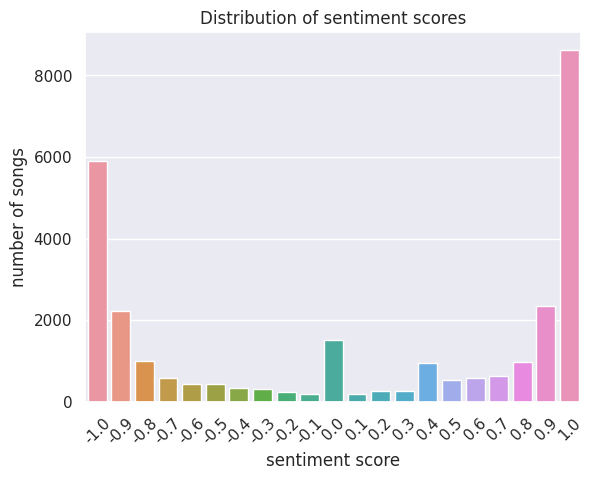

In [90]:
df_lyrics['sentiment_gr'] = df_lyrics['sentiment'].round(1)
lyrics_sen = df_lyrics.groupby('sentiment_gr')['title'].nunique().reset_index()
sns.set_theme(style="darkgrid")
sns.barplot(x='sentiment_gr', y='title', data=lyrics_sen)
plt.xticks(rotation = 45)

# add a title and labels to the plot
plt.title('Distribution of sentiment scores')
plt.xlabel('sentiment score')
plt.ylabel('number of songs')

# display the plot
plt.show()

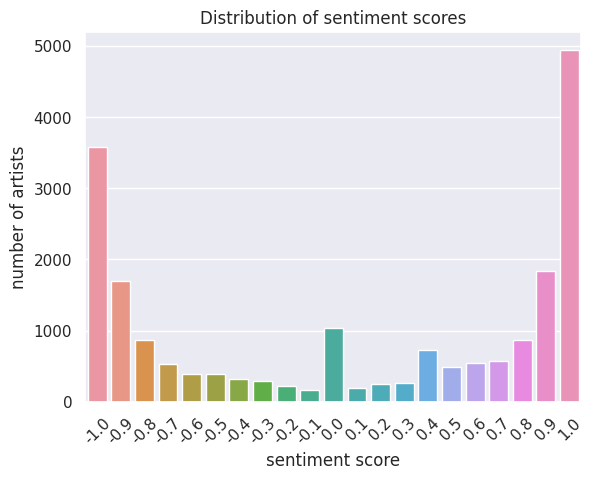

In [91]:
lyrics_sen_artist = df_lyrics.groupby('sentiment_gr')['artist'].nunique().reset_index()
sns.set_theme(style="darkgrid")
sns.barplot(x='sentiment_gr', y='artist', data=lyrics_sen_artist)
plt.xticks(rotation = 45)

# add a title and labels to the plot
plt.title('Distribution of sentiment scores')
plt.xlabel('sentiment score')
plt.ylabel('number of artists')

# display the plot
plt.show()

### Feature engineering: Extract words from lyrics


I wanted to add a columns counting unique words and total words to the final ```df_lyrics``` as we were curious to see if these features impacted a song's success. 

In [92]:
#drop unnamed column
df_lyrics.drop(columns = ['Unnamed: 0'], inplace=True)

Get the total word count and unique words for each song. 

In [93]:
word_counts = []
unique_word_counts = []
for i in range (0, len(df_lyrics)):
    word_counts.append(len(df_lyrics.iloc[i]['lyrics'].split()))
    unique_word_counts.append(len(set(df_lyrics.iloc[i]['lyrics'].split())))
df_lyrics['word counts'] = word_counts
df_lyrics['unique word counts'] = unique_word_counts

Create the final lyrics dataset for merging with other datasets.

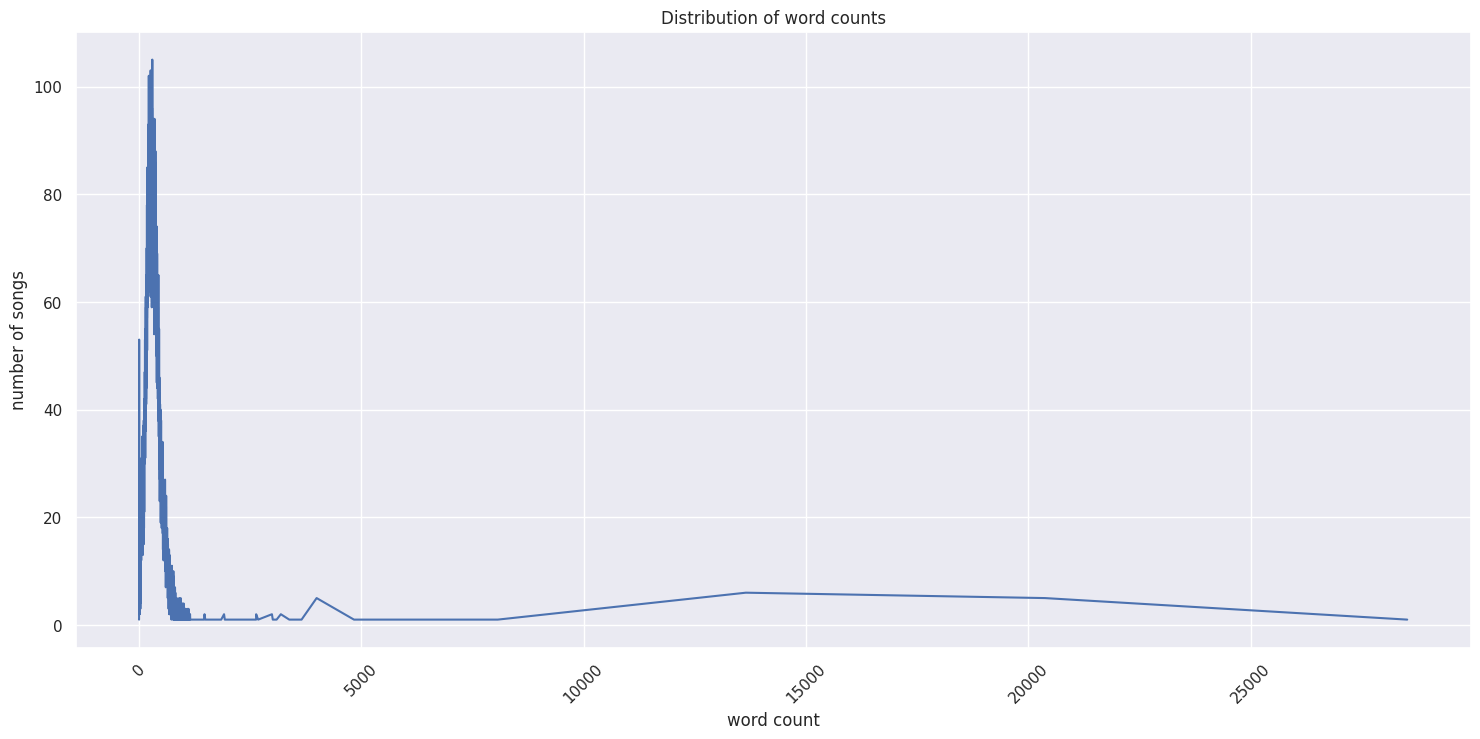

In [94]:
lyrics_sen_artist = df_lyrics.groupby('word counts')['title'].nunique().reset_index()
sns.set_theme(style="darkgrid")
plt.figure(figsize=(18, 8))
sns.lineplot(x='word counts', y='title', data=lyrics_sen_artist)
plt.xticks(rotation = 45)

# add a title and labels to the plot
plt.title('Distribution of word counts')
plt.xlabel('word count')
plt.ylabel('number of songs')

# display the plot
plt.show()

Review the number of songs that have a very high word count, we may need to drop these as outliers.

In [95]:
df_lyrics_high_counts = df_lyrics[df_lyrics['word counts'] >= 1000]
df_lyrics_high_counts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 346 to 30361
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               209 non-null    object 
 1   artist              209 non-null    object 
 2   lyrics              209 non-null    object 
 3   song URL            209 non-null    object 
 4   clean URL           209 non-null    object 
 5   clean artist        209 non-null    object 
 6   URL letters         209 non-null    object 
 7   tokenized           209 non-null    object 
 8   sentiment           209 non-null    float64
 9   sentiment_gr        209 non-null    float64
 10  word counts         209 non-null    int64  
 11  unique word counts  209 non-null    int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 21.2+ KB


In [96]:
df_lyrics_high_counts.head()

,title,artist,lyrics,song URL,clean URL,clean artist,URL letters,tokenized,sentiment,sentiment_gr,word counts,unique word counts
346,Antes y Después,"Anuel AA, Kendo Kaponi, Yandel, Ñengo Flow","Brr Anuel Ante' y despué’, ¿oíste, cabrón? ...",https://genius.com/Anuel-aa-kendo-kaponi-and-y...,https://genius.com/anuelaakendokaponiandyandel...,"anuelaa,kendokaponi,yandel,ñengoflow",an,"[brr, anuel, despué, cabrón, acosté, dormir, p...",-0.9927,-1.0,1394,684
539,a lot,21 Savage,I love you Turn my headphone down a little bi...,https://genius.com/21-savage-a-lot-lyrics,https://genius.com/21savagealotlyrics,21savage,21,"[love, turn, headphone, little, bit, yeah, man...",-0.9942,-1.0,1059,325
785,Te Boté - Remix,"Nio Garcia, Casper Magico, Bad Bunny, Darell, ...","Wo-oh Oh-oh (Oh-oh) Wo-oh, yeh (Yeh-yeh) Est...",https://genius.com/Nio-garcia-casper-magico-an...,https://genius.com/niogarciacaspermagicoandbad...,"niogarcia,caspermagico,badbunny,darell,ozuna,n...",ni,"[yeh, verdadero, remix, así, ozuna, paso, much...",-0.9964,-1.0,1133,492
1029,New Patek,Lil Uzi Vert,"Hmm New Patek on my wrist White diamonds, the...",https://genius.com/Lil-uzi-vert-new-patek-lyrics,https://genius.com/liluzivertnewpateklyrics,liluzivert,li,"[hmm, new, patek, wrist, white, diamonds, shit...",-0.9997,-1.0,1590,502
1467,Devil's Work,Joyner Lucas,"Father, forgive me I'm staring at this Bible...",https://genius.com/Joyner-lucas-devils-work-ly...,https://genius.com/joynerlucasdevilsworklyrics,joynerlucas,jo,"[father, forgive, staring, bible, keep, glanci...",0.8470,0.8,1002,461


In [97]:
df_lyrics_zero = df_lyrics[df_lyrics['word counts'] < 10]
df_lyrics_zero.head()

,title,artist,lyrics,song URL,clean URL,clean artist,URL letters,tokenized,sentiment,sentiment_gr,word counts,unique word counts
1904,Legion Inoculant,TOOL,Bless this immunityYou might also like3Embed,https://genius.com/Tool-legion-inoculant-lyrics,https://genius.com/toollegioninoculantlyrics,tool,to,"[bless, immunityyou, might]",0.4215,0.4,6,6
2214,Legion Inoculant,TOOL,Bless this immunityYou might also like3Embed,https://genius.com/Tool-legion-inoculant-lyrics,https://genius.com/toollegioninoculantlyrics,tool,to,"[bless, immunityyou, might]",0.4215,0.4,6,6
2423,Insert Coin,Slipknot,I'm counting all the killersYou might also lik...,https://genius.com/Slipknot-insert-coin-lyrics,https://genius.com/slipknotinsertcoinlyrics,slipknot,sl,"[counting, killersyou, might]",0.0000,0.0,8,8
3589,Horse,Salvatore Ganacci,"""What?""You might also like3Embed",https://genius.com/Salvatore-ganacci-horse-lyrics,https://genius.com/salvatoreganaccihorselyrics,salvatoreganacci,sa,[might],0.0000,0.0,4,4
3681,Emerald Rush,Jon Hopkins,You might also likeEmbed,https://genius.com/Jon-hopkins-emerald-rush-ly...,https://genius.com/jonhopkinsemeraldrushlyrics,jonhopkins,jo,"[might, likeembed]",0.0000,0.0,4,4


On inspection the lyrics in `df_lyrics_high_counts` don't seem like valid song lyrics, the API must have scraped more from some pages than just the lyrics, so we'll remove these rows. The lyrics in `df_lyrics_zero` seem to all include an extra piece of text "You might also like...", which we could clean from the lyrics column of each row, but we can also see that this phrase has no bearing on the sentiment, as evidenced by the bottom three rows, so while the lyrics column itself is not totally clean, since we'll only be using the sentiment column for analysis, and since that is clean, there is no need to clean the lyrics column of this extra string.

In [98]:
# drop outliers
df_lyrics = df_lyrics[df_lyrics['word counts'] <= 2500]

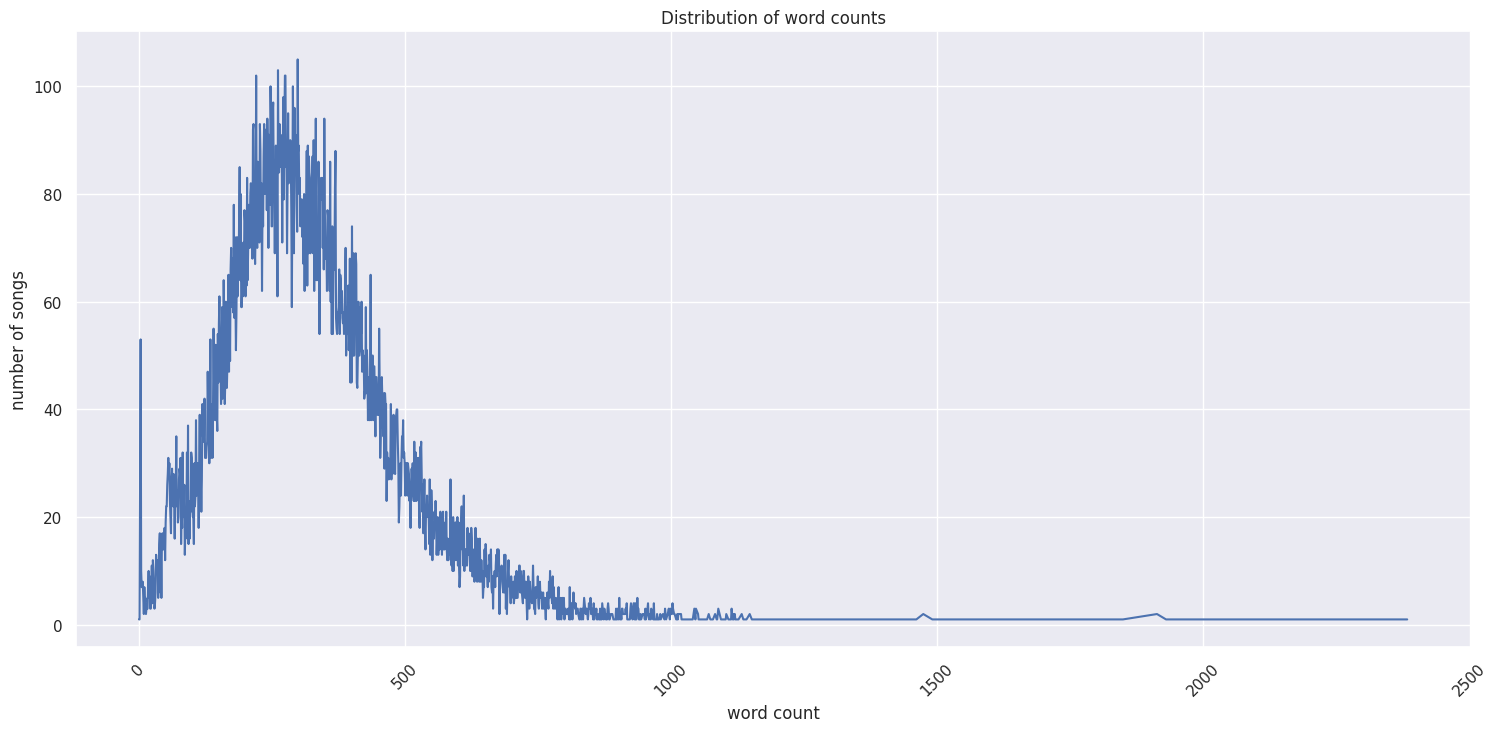

In [99]:
lyrics_sen_artist = df_lyrics.groupby('word counts')['title'].nunique().reset_index()
sns.set_theme(style="darkgrid")
plt.figure(figsize=(18, 8))
sns.lineplot(x='word counts', y='title', data=lyrics_sen_artist)
plt.xticks(rotation = 45)

# add a title and labels to the plot
plt.title('Distribution of word counts')
plt.xlabel('word count')
plt.ylabel('number of songs')

# display the plot
plt.show()

Create the final lyrics dataset for merging with other datasets.

In [100]:
df_lyrics_ready = df_lyrics[['title', 'artist', 'sentiment', 'sentiment_gr','word counts', 'unique word counts']]

In [101]:
df_lyrics_ready.shape[0]

30386

# Final dataset creation



The final datasets are merged together and inspected

The datasets are:
1.   `df_trend_ranking`
2.   `df_lyrics_ready`
3.   `df_charts_features_tiktok`












In [102]:
df_final = df_charts_features_tiktok.merge(df_lyrics_ready, left_on = ['title', 'artist'], right_on = ['title', 'artist'], how = 'inner')
df_final.drop_duplicates(inplace=True)

In [103]:
print(len(df_final))

30006


In [104]:
df_final.head()

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop,sentiment,sentiment_gr,word counts,unique word counts
0,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.6880,0.16800,0.2480,0.03494,-0.9985,-1.0,490,264
1,"""99""",Barns Courtney,15,2018,199413,95.980,0.804,0.552,0.111,0.7140,0.00598,0.0303,0.03494,0.9729,1.0,238,120
2,"""BOP""",CJ,199,2021,110375,139.144,0.741,0.885,0.342,0.6030,0.35700,0.3810,0.00000,0.8495,0.8,356,127
3,"""Eungenio"" Salvador Dali",Mecano,49,2018,325120,72.328,0.323,0.458,0.117,0.0432,0.86000,0.0503,0.03494,-0.5267,-0.5,225,132
4,"""Jag fakking hatar er""","ODZ, Young Earth Sauce",53,2018,145969,130.144,0.822,0.786,0.181,0.6010,0.20000,0.2380,0.03494,-0.6767,-0.7,529,279


In [105]:
df_final = df_final.merge(df_trend_ranking, on = ['artist', 'Year'], how = 'left', indicator = True)

In [106]:
df_final.head()

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,...,speechiness,tiktok_pop,sentiment,sentiment_gr,word counts,unique word counts,Best_Ranking_Position,Days_Trending_US,Days_Trending_ROW,_merge
0,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.6880,...,0.2480,0.03494,-0.9985,-1.0,490,264,2,0.0,195.0,both
1,"""99""",Barns Courtney,15,2018,199413,95.980,0.804,0.552,0.111,0.7140,...,0.0303,0.03494,0.9729,1.0,238,120,15,0.0,19.0,both
2,"""BOP""",CJ,199,2021,110375,139.144,0.741,0.885,0.342,0.6030,...,0.3810,0.00000,0.8495,0.8,356,127,1,175.0,9552.0,both
3,"""Eungenio"" Salvador Dali",Mecano,49,2018,325120,72.328,0.323,0.458,0.117,0.0432,...,0.0503,0.03494,-0.5267,-0.5,225,132,12,0.0,53.0,both
4,"""Jag fakking hatar er""","ODZ, Young Earth Sauce",53,2018,145969,130.144,0.822,0.786,0.181,0.6010,...,0.2380,0.03494,-0.6767,-0.7,529,279,15,0.0,34.0,both


In [107]:
print(len(df_final))

30006


In [108]:
df_final['Best_Ranking_Position'] = df_final['Best_Ranking_Position'].fillna(0)
df_final['Days_Trending_US'] = df_final['Days_Trending_US'].fillna(0)
df_final['Days_Trending_ROW'] = df_final['Days_Trending_ROW'].fillna(0)

In [109]:
df_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30006 entries, 0 to 30005
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   title                  30006 non-null  object  
 1   artist                 30006 non-null  object  
 2   rank                   30006 non-null  int64   
 3   Year                   30006 non-null  int64   
 4   duration_ms            30006 non-null  int64   
 5   tempo                  30006 non-null  float64 
 6   energy                 30006 non-null  float64 
 7   danceability           30006 non-null  float64 
 8   liveness               30006 non-null  float64 
 9   valence                30006 non-null  float64 
 10  acousticness           30006 non-null  float64 
 11  speechiness            30006 non-null  float64 
 12  tiktok_pop             30006 non-null  float64 
 13  sentiment              30006 non-null  float64 
 14  sentiment_gr           30006 non-null 

Tempo should be converted to `float64`.

In [110]:
df_final['tempo'] = df_final['tempo'].apply(lambda x: float(x))
df_final['tempo'] = df_final['tempo'].astype('float64')

Standardise column names.



In [111]:
df_final.rename(columns = {"Year": "year", "word counts":"word_counts", "unique word counts": "unique_word_counts", "Best_Ranking_Position":"best_ranking_position",
                           "Days_Trending_US": "days_trending_US","Days_Trending_ROW": "days_trending_ROW"}, inplace=True)

In [112]:
df_final.drop(columns = ['_merge'], inplace = True)

In [113]:
df_final.head()

,title,artist,rank,year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop,sentiment,sentiment_gr,word_counts,unique_word_counts,best_ranking_position,days_trending_US,days_trending_ROW
0,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.6880,0.16800,0.2480,0.03494,-0.9985,-1.0,490,264,2,0.0,195.0
1,"""99""",Barns Courtney,15,2018,199413,95.980,0.804,0.552,0.111,0.7140,0.00598,0.0303,0.03494,0.9729,1.0,238,120,15,0.0,19.0
2,"""BOP""",CJ,199,2021,110375,139.144,0.741,0.885,0.342,0.6030,0.35700,0.3810,0.00000,0.8495,0.8,356,127,1,175.0,9552.0
3,"""Eungenio"" Salvador Dali",Mecano,49,2018,325120,72.328,0.323,0.458,0.117,0.0432,0.86000,0.0503,0.03494,-0.5267,-0.5,225,132,12,0.0,53.0
4,"""Jag fakking hatar er""","ODZ, Young Earth Sauce",53,2018,145969,130.144,0.822,0.786,0.181,0.6010,0.20000,0.2380,0.03494,-0.6767,-0.7,529,279,15,0.0,34.0


Clean-up to save memory

In [114]:
del df_charts 
del df_song_features_1
del df_song_features_2 
del df_song_features_3 
del df_song_features_4
del df_song_features_5 
del df_song_features_6 
del df_song_features_7 
del df_song_features_10 
del df_tiktok_19 
del df_tiktok_20
del df_tiktok_21
del max_ranking_df 
del feature_matches
del features_10_rename_map
del features_11_rename_map
del features_12_rename_map
del features_2_rename_map
del features_1_rename_map
del features_5_rename_map
del features_3_rename_map
del features_4_rename_map
del features_7_rename_map
del features_8_rename_map
del features_9_rename_map
del df_song_features_9
del df_song_features_8
del df_tiktok_full_merge
gc.collect()

17331

# Final dataset EDA

## Word clouds

Let's explore the most common words in songs per year. We decided to focus on frequent words that were unique for each year due to the overlap of very common words each year, e.g. yeah, know, like, love. 



In [115]:
df_lyrics_year = df_lyrics.merge(df_final[['title', 'year']], on='title', how = 'inner')

In [116]:
df_lyrics_year = df_lyrics_year[['title', 'year', 'lyrics']]

In [117]:
lyrics_2017 = df_lyrics_year.loc[df_lyrics_year['year'] == 2017, 'lyrics'].tolist()
top_tokens_list = [tokenize_content(x) for x in lyrics_2017]
top_tokens_2017 = [t for sublist in top_tokens_list for t in sublist]

In [118]:
lyrics_2018 = df_lyrics_year.loc[df_lyrics_year['year'] == 2018, 'lyrics'].tolist()
top_tokens_list = [tokenize_content(x) for x in lyrics_2018]
top_tokens_2018 = [t for sublist in top_tokens_list for t in sublist]

In [119]:
lyrics_2019 = df_lyrics_year.loc[df_lyrics_year['year'] == 2019, 'lyrics'].tolist()
top_tokens_list = [tokenize_content(x) for x in lyrics_2019]
top_tokens_2019 = [t for sublist in top_tokens_list for t in sublist]

In [120]:
lyrics_2020 = df_lyrics_year.loc[df_lyrics_year['year'] == 2020, 'lyrics'].tolist()
top_tokens_list = [tokenize_content(x) for x in lyrics_2020]
top_tokens_2020 = [t for sublist in top_tokens_list for t in sublist]

In [121]:
lyrics_2021 = df_lyrics_year.loc[df_lyrics_year['year'] == 2021, 'lyrics'].tolist()
top_tokens_list = [tokenize_content(x) for x in lyrics_2021]
top_tokens_2021 = [t for sublist in top_tokens_list for t in sublist]

In [147]:
n = 1500  # adjust this for more or less words in the word cloud
word_counts = Counter(top_tokens_2017)
top_most_common = word_counts.most_common(n)
print("2017:", top_most_common)
# and save only the words that are in english and not sensitive or profane
words_2017 = set([x[0] for x in top_most_common if detect(x[0]) == 'en'])

word_counts = Counter(top_tokens_2018)
top_most_common = word_counts.most_common(n)
print("2018:", top_most_common)  
words_2018 = set([x[0] for x in top_most_common if detect(x[0]) == 'en'])

word_counts = Counter(top_tokens_2019)
top_most_common = word_counts.most_common(n)
print("2019:", top_most_common) 
words_2019 = set([x[0] for x in top_most_common if detect(x[0]) == 'en'])

word_counts = Counter(top_tokens_2020)
top_most_common = word_counts.most_common(n)
print("2020:", top_most_common) 
words_2020 = set([x[0] for x in top_most_common if detect(x[0]) == 'en'])

word_counts = Counter(top_tokens_2021)
top_most_common = word_counts.most_common(n)
print("2021:", top_most_common)
words_2021 = set([x[0] for x in top_most_common if detect(x[0]) == 'en'])

2017: [('like', 43642), ('yeah', 34174), ('know', 33036), ('oh', 32792), ('love', 30524), ('na', 29773), ('got', 27305), ('get', 20628), ('might', 20321), ('baby', 19367), ('go', 19341), ('let', 17672), ('want', 15726), ('one', 15644), ('time', 14791), ('wan', 14663), ('never', 14636), ('say', 14248), ('ca', 13772), ('come', 13136), ('feel', 13091), ('see', 13029), ('make', 12528), ('way', 12334), ('back', 12020), ('take', 11851), ('gon', 11813), ('need', 11220), ('could', 10307), ('right', 10215), ('night', 9484), ('ooh', 9424), ('tell', 9158), ('away', 8663), ('life', 8382), ('girl', 8102), ('give', 7946), ('heart', 7818), ('keep', 7650), ('think', 7631), ('hey', 7359), ('good', 7108), ('home', 6988), ('still', 6743), ('every', 6557), ('day', 6530), ('mind', 6273), ('would', 6235), ('us', 6151), ('better', 6124), ('said', 6104), ('little', 6004), ('world', 5815), ('look', 5574), ('always', 5559), ('si', 5549), ('around', 5451), ('run', 5415), ('hold', 5357), ('ever', 5201), ('long', 

Words like "like" and "yeah" are popular in every year. Are there any words that are uniquely frequent in each year?

In [148]:
unique_to_2017 = words_2017 - words_2021 - words_2020 - words_2019 - words_2018 - set(sensitive_words)
unique_to_2018 = words_2018 - words_2021 - words_2020 - words_2019 - words_2017 - set(sensitive_words)
unique_to_2019 = words_2019 - words_2021 - words_2020 - words_2018 - words_2017 - set(sensitive_words)
unique_to_2020 = words_2020 - words_2021 - words_2019 - words_2018 - words_2017 - set(sensitive_words)
unique_to_2021 = words_2021 - words_2020 - words_2019 - words_2018 - words_2017 - set(sensitive_words)

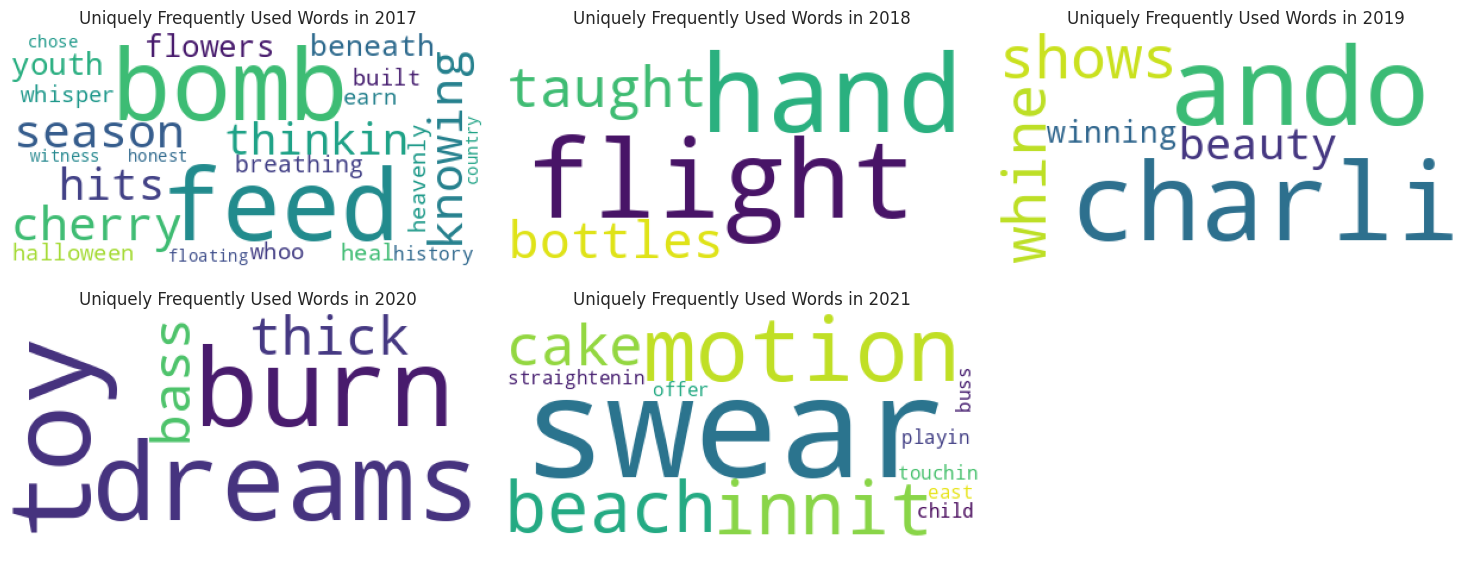

In [149]:
# create a list of top tokens for each year
top_tokens_list = [unique_to_2017, unique_to_2018, unique_to_2019, unique_to_2020, unique_to_2021]

# create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()

# loop through each year and create a word cloud subplot
for i in range(len(top_tokens_list)):
    wordcloud_frequencies = Counter(top_tokens_list[i])
    top_tokens_wordcloud = WordCloud(background_color='white').generate_from_frequencies(wordcloud_frequencies)
    ax = axes[i]
    ax.imshow(top_tokens_wordcloud)
    ax.set_title("Uniquely Frequently Used Words in " + str(i + 2017))
    ax.axis('off')

# make the last subplot invisible and remove its axes
axes[-1].set_visible(True)
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Determining Ranking Classes

To determine how to classify the data, we look at the distribution of ranks in the dataset. This is necessary because if we attempt to build a classifier based on training data that is imbalanced, with a significant majority of training instances in one class and very few in another, then we won't arrive at an accurate model. We can visualize the rank distribution in order to get a sense of where to draw the lines between classes so as to have balanced data.

We would like to predict the following categories:

*   top 10 hit
*   top 100 
*   top 200

In [126]:
df_final_position =  df_final.groupby("rank")['title'].count()

In [127]:
print(df_final_position)

rank
1      1902
2       961
3       754
4       756
5       713
       ... 
196      28
197      22
198      27
199      31
200      32
Name: title, Length: 200, dtype: int64


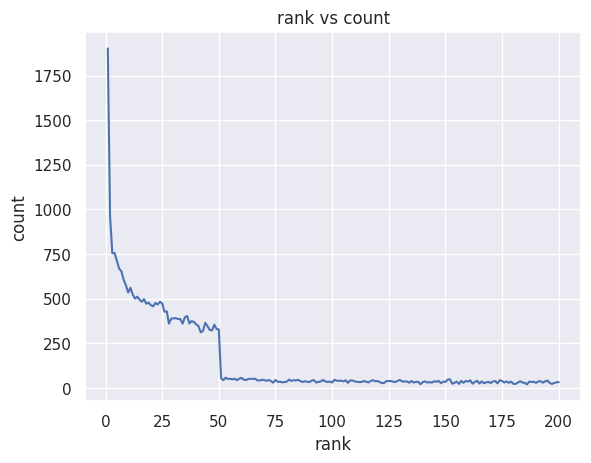

In [128]:
import matplotlib.pyplot as plt
# plot the data
plt.plot(df_final_position)

# set the plot title and axis labels
plt.title('rank vs count')
plt.xlabel('rank')
plt.ylabel('count')

# show the plot
plt.show()

In [129]:
rows_1 = len(df_final[(df_final['rank'] == 1)])
rows_top_10 = len(df_final[(df_final['rank'] <= 10)& (df_final['rank'] > 1)])
rows_top_25 = len(df_final[(df_final['rank'] <= 25)& (df_final['rank'] > 10)])
rows_top_50 = len(df_final[(df_final['rank'] <= 50)& (df_final['rank'] >25)])
rows_top_100 = len(df_final[(df_final['rank'] <= 100)& (df_final['rank'] > 41)])
rows_top_200 = len(df_final[(df_final['rank'] <= 200)& (df_final['rank']> 100)])
rows_zero = len(df_final[(df_final['rank'] == 0)])
rows_over_200 = len(df_final[(df_final['rank'] >200)])
rows_total = len(df_final)

print("rows 1:", rows_1, int((rows_1/rows_total)*100))
print("rows top 10:", rows_top_10, int((rows_top_10/rows_total)*100))
print("rows top 25:", rows_top_25, int((rows_top_25/rows_total)*100))
print("rows top 50:", rows_top_50, int((rows_top_50/rows_total)*100))
print("rows top 100:", rows_top_100, int((rows_top_100/rows_total)*100))
print("rows top 200:", rows_top_200, int((rows_top_200/rows_total)*100))

#print("rows 0:", rows_zero, int((rows_zero/rows_total)*100))
#print("rows over 200:", rows_over_200, int((rows_over_200/rows_total)*100))
print("total rows:", rows_total)

rows 1: 1902 6
rows top 10: 6219 20
rows top 25: 7337 24
rows top 50: 9116 30
rows top 100: 5072 16
rows top 200: 3357 11
total rows: 30006


We add the rank group to the final dataframe so that we have our classifications in place. 

In [130]:
df_final['rank_group'] = pd.cut(df_final['rank'], bins=[0, 10, 100, 200], labels=[10,100,200])
df_final.head()

,title,artist,rank,year,duration_ms,tempo,energy,danceability,liveness,valence,...,speechiness,tiktok_pop,sentiment,sentiment_gr,word_counts,unique_word_counts,best_ranking_position,days_trending_US,days_trending_ROW,rank_group
0,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.6880,...,0.2480,0.03494,-0.9985,-1.0,490,264,2,0.0,195.0,100
1,"""99""",Barns Courtney,15,2018,199413,95.980,0.804,0.552,0.111,0.7140,...,0.0303,0.03494,0.9729,1.0,238,120,15,0.0,19.0,100
2,"""BOP""",CJ,199,2021,110375,139.144,0.741,0.885,0.342,0.6030,...,0.3810,0.00000,0.8495,0.8,356,127,1,175.0,9552.0,200
3,"""Eungenio"" Salvador Dali",Mecano,49,2018,325120,72.328,0.323,0.458,0.117,0.0432,...,0.0503,0.03494,-0.5267,-0.5,225,132,12,0.0,53.0,100
4,"""Jag fakking hatar er""","ODZ, Young Earth Sauce",53,2018,145969,130.144,0.822,0.786,0.181,0.6010,...,0.2380,0.03494,-0.6767,-0.7,529,279,15,0.0,34.0,100


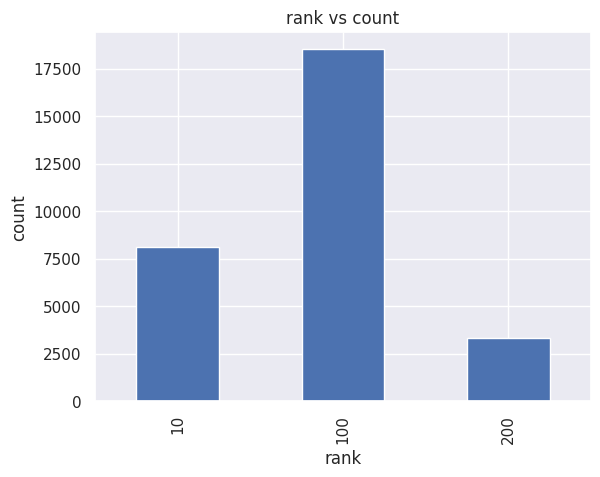

In [131]:
# group and plot the data again
df_final_rank_groups = df_final.groupby("rank_group")['title'].count()

# plot the data
df_final_rank_groups.plot(x='rank_group', y='title', kind='bar')

# set the plot title and axis labels
plt.title('rank vs count')
plt.xlabel('rank')
plt.ylabel('count')

# show the plot
plt.show()

In [132]:
df_final_rank_review = df_final.groupby(by=['rank_group']).agg({'duration_ms':['mean', 'min', 'max'],'sentiment_gr':['mean', 'min', 'max'],'word_counts':['mean', 'min', 'max'],'unique_word_counts':['mean', 'min', 'max'],'best_ranking_position':['mean', 'min', 'max'],'days_trending_ROW':['mean', 'min', 'max'],'days_trending_US':['mean', 'min', 'max']})

print(df_final_rank_review)

              duration_ms                 sentiment_gr           word_counts  \
                     mean    min      max         mean  min  max        mean   
rank_group                                                                     
10          216398.695111  29668   798573     0.101084 -1.0  1.0  346.753725   
100         222830.570596  30133  1283747     0.144139 -1.0  1.0  324.629696   
200         212029.874293  30301   645667     0.137146 -1.0  1.0  335.801311   

                     unique_word_counts  ...       best_ranking_position      \
           min   max               mean  ...   max                  mean min   
rank_group                               ...                                   
10           1  2225         144.254895  ...  1111              4.138283   1   
100          4  2262         134.321675  ...  1073             18.382880   1   
200          4  2383         141.870718  ...   874             48.169794   1   

                days_trending_ROW     

We can see that there is class imbalance that will need to be addressed at the modelling stage. 

## Visualizing Trends Over Time

Before modeling and making predictions about what features contribute to a song's success, lets do some explorative data analysis to understand the data better. We'll explore and visualize the answers to questions such as

- Have tastes in music been changing over time?



KeyboardInterrupt: ignored

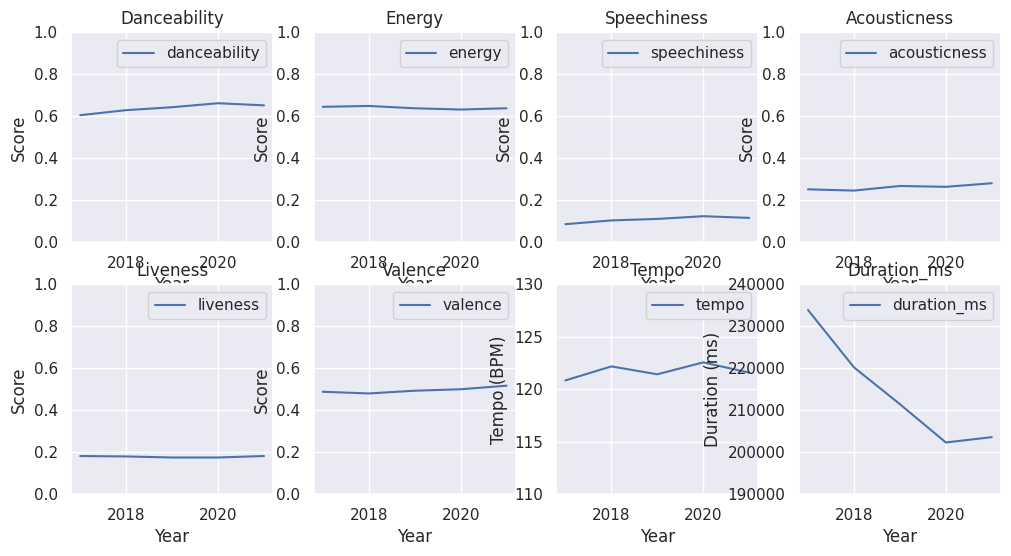

In [133]:
# Lets get the average audio feature in every country in every year
average_features = df_final[['year', 'danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms']].groupby(by=['year'], as_index=False).mean().round(3)

# define the size of each subplot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# iterate through each feature and plot it in a subplot
for i, feature in enumerate(['danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms']):
    ax = axes[i//4, i%4]
    average_features.plot(x='year', y=feature, ax=ax)
    ax.set_title(feature.capitalize())
    ax.set_xlabel('Year')
    ax.set_ylabel('Score')
    
    if feature in ['danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence']:
        ax.set_ylim(0, 1)
    elif feature == 'tempo':
        ax.set_ylim(110, 130)
        ax.set_ylabel('Tempo (BPM)')
    elif feature == 'duration_ms':
        ax.set_ylim(190000, 240000)
        ax.set_ylabel('Duration (ms)')

plt.tight_layout()
plt.legend()
plt.show()

The most significant change, which seems true from personal experience, is that average song duration in the charts got shorter from 2017 to 2021, from roughly 3 min 40 seconds to roughly 3 min 25 seconds. We can also see that there is a slight increase in Tempo, Valence, Acousticness and Danceability in the same period. It is worth noting that the averages calculated above include multiple entries per song if it charted in multiple countries. The effect is that the more popular a song is worldwide, the more heavily its features are weighted in the graphs above.

Lets do the same with some of the lyric data. What about sentiment, has that changed through time? The amount of words used in songs?

In [ ]:
sentiment_by_year = df_final[['year', 'sentiment', 'word_counts', 'unique_word_counts']].groupby(by=['year'], as_index=False).mean()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

# iterate through each feature and plot it in a subplot
for i, feature in enumerate(['sentiment', 'word_counts', 'unique_word_counts']):
  ax = axes[i]
  sentiment_by_year.plot(x='year', y=feature, ax=ax)
  plt.xlabel('Year')
  ax.set_ylabel(feature)
  plt.xticks(sentiment_by_year['year'])
  if i == 1:
    ax.set_title('Average Sentiment, Word Count, and Unique Word Count by Year')

plt.show()

Interestingly, while the mean sentiment is positive, it became slighly less so through 2020 (perhaps correlating with Covid?), with a slight rebound in 2021. Another interesting trend is that word count seems to have had an inverse trend to the sentiment.

## Correlation between features 

Drop colums that won't be used for analysis and separate out rank as it will be the predicted dataset. 

In [ ]:
df_features_matrix = df_final.drop(['artist','sentiment','title', 'rank_group', 'year'], axis=1)

In [ ]:
# Create scatter matrix with only one row and include sepal_width, petal_length, and petal_width features
sns.pairplot(df_features_matrix, x_vars=['rank'], height=3, aspect=1.5, plot_kws={'s': 10})
plt.xticks(rotation=45)
plt.show()

In [ ]:
corr_matrix = df_features_matrix.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# create a heatmap plot of the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f',vmin=-1, vmax=1, mask=mask)

plt.show()

The correlation matrix has some interesting insights! But we have to be careful about how we interpret it, since a "High" rank is actually a low number, and a "Low" rank is actually a high number.

Aside from some obvious multicollinearities which must be addressed ebfore modelling, we can see that rank is actually not very correlated with any one feature. The largest correlation in magnitude is with tiktop popularity, at -0.07. This means that as a song becomes more popular on TikTok, its rank decreases, i.e. it also becomes more popular on Spotify. This answers one of our initial questions, espeically when compare that correlation with the correlations for "days_trending_US" and "days_trending_ROW". Both of these metrics measure how popular an artist was - their promenence - in the year of the release. We can see that being a prominent artist with ranking, but not as much as TikTok popularity does, which indicates that perhaps TikTok virality is becoming a bigger driver of song success than fame.

Other interesting insights are that speechiness is much more highly correlated with trending in the US than in the rest of the world, indicating that perhaps Rap music is more popular in the US. Also, perhaps surprisingly is the insight that duration is negatively correlated with rank, meaning that as a song gets shorter, it is more likely to rank poorly (although this correlation is only 0.04). Also, out of all the audio features, danceability is the only one that correlates with better rankings.

With recards to colinearity, we can see that word counts and unique word counts are highly correlated and days trending in the US and days trending in the ROW are highly correlated so we will remove one of each of these features from the final analysis. 

In [ ]:
del df_features_matrix
gc.collect()

In [ ]:
del corr_matrix
gc.collect()

# Modeling: K-Means Clustering 

## Are There Natural Groupings of Popular Styles of Music?

Subjectively, we have experienced that there are different styles of popular music. Dance music, acoustic singer-songwriter, electronic, etc., may be among the different types of charting popular music. Is it possible to identify an natural clusters of songs in the charts based on audio feature or lyric sentiment?

We'll experiment with K-Means Clustering to see if any natural groupings emerge.

First, lets decide on which features are relevant to the k-means clustering. For example, song title, artist, and year are not relevant.

In [ ]:
possibly_relevant_features = ['duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness', 'sentiment', 'word_counts', 'unique_word_counts']

# create an empty list to store the sum of squared distances for each k
ssd = []
k_range = range(1, len(possibly_relevant_features))

# fit KMeans for each k value and record the sum of squared distances
for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    km.fit(df_final[possibly_relevant_features])
    ssd.append(km.inertia_)
# plot the elbow curve
plt.plot(k_range, [x/max(ssd) for x in ssd], 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Normalized Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

It looks like k=6 clusters contains 90 percent of the information of natural groupings, at which point there are diminishing returns for increasing k. Is it possible to narrow down the subset of features that contain most of the information of natural groupings?

In [ ]:
import itertools
import math

feature_cols = ['duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness', 'sentiment','word_counts', 'unique_word_counts']
n_features = 7

ssd_results = [math.inf] * (n_features-1)
subsets = [0] * (n_features-1)

for r in range(2, n_features+1):
    for subset in itertools.combinations(feature_cols, r):  # iterate through all combinations of features
        subset = list(subset)
        # since prev r-1 feature subset explained the most of the clustering, next feature subset should include those features. speeds up run time
        if r > 2 and not set(subsets[r-3]).issubset(set(subset)):
          continue
        km = KMeans(n_clusters=6, init='k-means++', random_state=42)
        km.fit(df_final[subset])
        # below, "/10**(r-1)" is a scaling factor so we can compare the sum mean squared distances of the k means clustering over different dimensions
        # We divide the sum of distances in two dimensions by 10^0. Divide the sum of distances in three dimensions by 10^1. In four dimensions, 10^2...
        if km.inertia_ / 10**(r-2) < ssd_results[r-2]:
          ssd_results[r-2] = km.inertia_ / 10**(r-2)  
          subsets[r-2] = subset

# plot the elbow curve for each subset of features
plt.plot(range(2, n_features+1), [x/max(ssd_results) for x in ssd_results], 'bx-')
plt.xlabel('Number of features')
plt.ylabel('Normalized Sum of Squared Distances')
plt.title('Elbow Method for Optimal Number of Features')
plt.show()

Clearly four or five features is the point at which we start seeing diminishing returns. Which features are those that contain the most information with respect to natural clustering? The five most relevant features for explaining the natural gourpings are:

In [ ]:
k_means_feature_subset = subsets[3]
subsets[3]

What does this mean? We can notice that, for example, 'sentiment' is not included in the list of features that contain the most information of the natural groupings. This means that while there is variation in sentiment among the songs, two songs with opposite sentiment but with the same energy level are more likely to belong to the same natural group than two songs with opposite energy levels but the same sentiment. Making this more relatable, this is to say that songs that are high energy, danceable, live, acoustic and speechy are most likely to belong to the same group, regardless of whether they contain positive or negative sentiment, are short or long, contain many or few words, etc.

It may be insightful in future modeling to have a cluster label column, which may end up being a strong predictor of success.

In [ ]:
km = KMeans(n_clusters=6, init='k-means++', random_state=42)
km.fit(df_final[subsets[3]])
df_final['cluster'] = km.predict(df_final[subsets[3]])
df_final[10986:10991][['title', 'artist','cluster']]  # look at random slice

Lets listen to some music and see if these clusters make sense subjectively!

Cluster 5:

[How Do I Live - LeAnn Rimes](https://youtu.be/1Olo8gzgpC4)

[How Do We Make It - Jarryd James](https://youtu.be/PZY_y-OWw4Y)

Cluster 1:

[How Do You Do! - Roxette](https://youtu.be/nx2iLOvP0rM)

[How Do You Feel? - The Maine](https://youtu.be/tku0H7YeMeA)

Subjectively, these songs in these clusters sound very similar! Interestingly, the second "How Do I Live" song is the same song, but with slightly different instrumentation.

[How Do I Live - Trisha Yearwood](https://youtu.be/Rcy6hNthQaA)

What are the characteristics of each of the clusters?

In [ ]:
df_cluster_means = df_final[subsets[3] + ['cluster']].groupby(by=['cluster']).mean()
df_cluster_means

Some insights that jump out right away are:
- Cluster 0 contains the most live sounding songs
- Cluster 1 contains the highest energy songs
- Cluster 2 contains the most danceable songs
- Cluster 3 contains acoustic high energy and danceable songs
- Cluster 4 contains mellow acoustic songs
- Cluster 5 contains more mellow, non-acoustic songs

Lets create columns for each of these clusters and one-hot encode so they can be used in further machine learning.

In [ ]:
clusters = ['genre_live', 'genre_high_energy_non_acoustic', 'genre_dance', 'genre_high_energy_dance', 'genre_mellow_acoustic', 'genre_mellow_non_acoustic']
for i in range(6):
  df_final[clusters[i]] = df_final['cluster'].apply(lambda x: 1 if x == i else 0)

And lets reduce the five dimensions that we calculated the k-means clustering over down to two via PCA to visualize the cluster distributions

In [ ]:
# FIXME: legend is incorrectly repeated one color twice. Error dissapears when deleting the labels= argument. Been hacking away at this for two hours and can't figure it out
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_final[k_means_feature_subset])
pca_df = pd.DataFrame({'Dimension 1': pca_scores[:,0], 'Dimension 2': pca_scores[:,1], 'cluster': df_final['cluster']})
ax = sns.scatterplot(data=pca_df, x='Dimension 1', y='Dimension 2', hue='cluster', palette='Set1')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Genre', labels=[clusters[i].replace('_', ' ').replace('genre ', '').capitalize() for i in range(6)])
plt.title('PCA Visualization of Genre Distributions')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=10, n_iter=250, n_iter_without_progress=50)  # Delete all args for clearer viz, longer run time
tsne_scores = tsne.fit_transform(df_final[k_means_feature_subset])
colors = sns.color_palette('Set1', n_colors=6)
tsne_df = pd.DataFrame({'Dimension 1': tsne_scores[:,0], 'Dimension 2': tsne_scores[:,1], 'cluster': df_final['cluster']})
ax = sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='cluster', palette=colors)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', labels=[clusters[i].replace('_', ' ').replace('genre ', '').capitalize() for i in range(6)], title='Genre')
plt.title('t-SNE Visualization of Genre Distributions')
plt.show()

## Song recommender
What metric can we use to recommend songs?

We'll assume that if a listener likes one particular song, the listener will also like songs with similar features. To create a list of recommended songs, we select the ones that are the nearest (measued as the euclidean distance) to the provided song.

In [ ]:
#Get selected song's parameters (use title and artist for seletion)
song = ('How Do I Live', 'LeAnn Rimes')
liked_song_full_features = df_final[(df_final['title']==song[0]) & (df_final['artist']==song[1])]

#Copy a subset of the features
liked_song_pred_features = liked_song_full_features[['energy', 'danceability', 'liveness', 'acousticness', 'speechiness']].copy()

#Prediction of in what cluster it should fit
pred = km.predict(liked_song_pred_features)

In [ ]:
#Calculate euclidean distance and select the 5 closest to the entered song

#Convert DF to Array
df_test = df_final[['energy', 'danceability', 'liveness', 'acousticness', 'speechiness']].to_numpy()

#Calculate euclidean distance for all songs to the selected song
distances = pd.DataFrame(euclidean_distances(liked_song_pred_features.to_numpy().reshape(1, -1), df_test)).transpose()

#Sort distances by descending order and pickt the top 6 (the first would be the selected song)
distances.rename(columns={0:'Distance'}, inplace=True)
recommendation = distances.sort_values("Distance", ascending=True).head(6)

#Join nearest six songs with df_final to get song details
recommendation = recommendation.join(df_final)

In [ ]:
# Project recomendation to selected fields
recommendation[['Distance','title','artist','energy', 'danceability', 'liveness', 'acousticness', 'speechiness']]

Given that somebody likes [How Do I Live, by LeAnn Rimes](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjor9--38j-AhX-EVkFHRFXA3UQyCl6BAgcEAM&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DMUFasKZcH_c&usg=AOvVaw3T47vFZxGt7UTNW9MDxYl4), here are the recommended songs:


[You Don't Do It For Me Anymore, by Demi Lovato	](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjFn-Lo38j-AhV2D1kFHaysBTIQyCl6BAgVEAM&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DymJsTWxziKI&usg=AOvVaw21sF72KlWlzBi_bR6ldStP)

[Girlie, by	Alexandra Savior](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiSjqL938j-AhWVMVkFHa0sDA0QyCl6BAgYEAM&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3D9a65ZcLM_1E&usg=AOvVaw1HPO8XfwBjsjgG1ak-X7Ms)

[Мамонтёнок, by LSP](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj-7OiM4Mj-AhXiFFkFHfSRDKkQtwJ6BAgOEAI&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DJQXoVfW3z6E&usg=AOvVaw1qT4Kx--1gHjZ_pscOX3b2)

[Always (Outro), by	Bryson Tiller](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiJ4bK74Mj-AhUXM1kFHQp3BoMQyCl6BAgVEAM&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3Dcx1fDepOJ20&usg=AOvVaw2fYNJVj-8dDecwbwPkjZ8L)

[蒲公英的約定, by	Jay Chou	](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiK6PPS4Mj-AhXsK1kFHTGaAU0QyCl6BAgVEAM&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DVitJnr3IySc&usg=AOvVaw23bTu8cyk16xJ1iGewIGJB)



#### Extending the recommendation algorithm to a list of songs

Now, let's try the same but with a list of songs instead of a single song. In this case, we calculate the mean of the features and then look for the Nearest Neighbours

In [ ]:
#Create a list of tuples (title, artist)
song_list = [('How Do I Live', 'LeAnn Rimes'), ('Ciega, Sordomuda', 'Shakira'), ('When To Say When', 'Drake'), ('Roar', 'Katy Perry')]

#Get selected song parameters (use title and artist for seletion)
liked_song_pred_features_list = []
for i in song_list:
  temp = df_final[(df_final['title']==i[0]) & (df_final['artist']==i[1])]
  temp = temp[['energy', 'danceability', 'liveness', 'acousticness', 'speechiness']]
  liked_song_pred_features_list.append(temp)
liked_song_pred_features_list = pd.concat(liked_song_pred_features_list)

#Calculate a new vector with mean of features
features_mean = pd.DataFrame(np.mean(liked_song_pred_features_list)).transpose()


In what cluster each of the songs fit individually?

In [ ]:
#iterate over liked songs to show to what cluster they belong to
for index, row in liked_song_pred_features_list.iterrows():
  cluster = km.predict(pd.DataFrame(row).transpose())
  print(df_final.iloc[index]['title'], ', by ', df_final.iloc[index]['artist'], ' belongs to cluster: ', cluster[0])

If the mean of the songs were a song, it'll be in Cluster 1: the highest energy songs.

In [ ]:
#Prediction of in what cluster it should fit. We're using this data 
pred = km.predict(features_mean)
print('Cluster for mean of liked songs: ', pred[0])

Now, let's look at the closest songs

In [ ]:
#Calculate euclidean distance and select the 5 closest to the song
df_test = df_final[['energy', 'danceability', 'liveness', 'acousticness', 'speechiness']].to_numpy()
distances = pd.DataFrame(euclidean_distances(features_mean.to_numpy().reshape(1, -1), df_test)).transpose()
distances.rename(columns={0:'Distance'}, inplace=True)
recommendation = distances.sort_values("Distance", ascending=True).head(6)
recommendation = recommendation.join(df_final)

And these are the recommended ones

In [ ]:
#Recommendation
recommendation[['Distance','title','artist','energy', 'danceability', 'liveness', 'acousticness', 'speechiness']]

In [ ]:
#iterate over liked songs to show to what cluster they belong to
for index, row in recommendation.iterrows():
  cluster = km.predict(pd.DataFrame(row[['energy', 'danceability', 'liveness', 'acousticness', 'speechiness']]).transpose())
  print(row['title'], ', by ',row['artist'], ' belongs to cluster: ', cluster[0])

All recommended songs belong to the same cluster a the mean of liked songs.

These are the liked songs:

[How Do I Live, by LeAnn Rimes	](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjor9--38j-AhX-EVkFHRFXA3UQyCl6BAgcEAM&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DMUFasKZcH_c&usg=AOvVaw3T47vFZxGt7UTNW9MDxYl4)

[Ciega, Sordomuda, by Shakira](https://www.youtube.com/watch?v=B3gbisdtJnA)

[When To Say When, by Drake](https://www.youtube.com/watch?v=qTNFIQyWe8M)

[Roar, by Katy Perry](https://www.youtube.com/watch?v=CevxZvSJLk8)


Here are the recommended songs:

[Too Bad, by IshDARR](https://www.youtube.com/watch?v=-heyCmkqwZM)

[Reuben James, by	Kenny Rogers & The First Edition](https://www.youtube.com/watch?v=8LthFi2T4Hk)

[Waiting On the World to Change, by	John Mayer](https://www.youtube.com/watch?v=oBIxScJ5rlY)

[Good Lovin', by	Benjamin Ingrosso	](https://www.youtube.com/watch?v=pwpmyvl2csc)

[Sharingan, by Reckol	](https://www.youtube.com/watch?v=MfOLZOcRA10)

[Crime Pays, by	Freddie Gibbs, Madlib	](https://www.youtube.com/watch?v=u8R7fmLYgi4)





# Modeling: Classifying hit songs

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
del sensitive_words
del df_lyrics
del df_lyrics_high_counts
del df_lyrics_negative
del df_lyrics_ready
del df_lyrics_positive
del df_lyrics_zero
del df_tiktok_matches_final
del df_tiktok_tracks_only
del df_features_artist_format_1
del df_features_artist_format_2
gc.collect()

In [ ]:
# stores features dataframe into variable called "features"
df_features = df_final.drop(columns = ['cluster', 'artist','sentiment', 'rank', 'rank_group', 'year', 'days_trending_ROW', 'unique_word_counts'])

# set title as the index
df_features.set_index('title', inplace=True)

# store the regression target variable into "prices"
rank = df_final['rank_group']

In [ ]:
df_features.info()

## Address class imbalances

During EDA we noted that our classes were not balanced with the topp 100 category having more datapoint. We will use SMOTE to correct class imbalances by oversampling classes that have less rows. 

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

# summarize class distribution
counter = Counter(rank)
print("Before SMOTE:",counter)
# transform the dataset
oversample = SMOTE(random_state=42)
df_features, rank = oversample.fit_resample(df_features, rank)
# summarize the new class distribution
counter = Counter(rank)
print("After SMOTE:", counter)

After SMOTE, we have 18,528 rows for each class. 

## Logistic Regression

Since we are working on a multi-class classification problem, we decided to test out logistic regression to start. 

We tried using two different multi_class methods. 'ovr' fits a binary problem for each label and ‘multinomial’ is the multinomial loss fit across the entire probability distribution.

The solver chosen was 'lbfgs' to account for the fact that the features have not yet been scaled and compatibility with the multi_class analysis. 

The max iterations value was set to 1000 because the model would not converge at the default value of 100.

Split data into test and training set. 

In [ ]:
# Assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
seed = 42
x = df_features
y = rank
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

In [ ]:
print("Training Data Size: features x:{},  label y:{}".format(x_train.shape, y_train.shape))
print("Testing Data Size: features x:{},  label y:{}".format(x_test.shape, y_test.shape))

In [ ]:
# Initialize model with default parameters and fit it on the training set
from sklearn.metrics import accuracy_score, classification_report
clf = LogisticRegression(multi_class = 'ovr', max_iter=10000, solver = 'lbfgs')
clf.fit(x_train,y_train)

# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(x_test)

# Find the accuracy and store the value in `log_acc`
train_accuracy = clf.score(x_train, y_train)
log_accuracy = accuracy_score(y_pred,y_test)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {log_accuracy}")
print(classification_report(y_test, y_pred))

We want to look beyond the accuracy score as this may not make it clear when there are issues classifying certain classes. In this model we can see that the under 10s class had an f1-score of 0.7 but the model didn't perform as well for the other classes. 

Next we tried setting 'multi_class' = 'multinomial'.

In [ ]:
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000, random_state=42)

# fit the model on the training data
clf.fit(x_train, y_train)

# predict the labels for the test data
y_pred = clf.predict(x_test)

# calculate the accuracy score
train_accuracy = clf.score(x_train, y_train)
log_multi_accuracy = accuracy_score(y_test, y_pred)
print(f"Train accuracy: {train_accuracy}")
print(f"Accuracy: {log_multi_accuracy}")

# print the classification report
print(classification_report(y_test, y_pred))

Changing to 'multi-nomial' did not improve performance much, we see the model is still best at predicting the top ten class. 

### PCA to reduce dimensionality

PCA transforms the features into a new set of uncorrelated features called principal components.

We wanted to see if it can reduce the complexity of our dataset and improve performance of the logistic regression model. The first step is to scale the data as regularisation is not scale invariant. 

In [ ]:
# Address scale-invariance
sc = StandardScaler()
x_scaled_train = sc.fit_transform(x_train)
x_scaled_test = sc.transform(x_test)

# Instantiate and Fit PCA
pca = PCA()
pca_fit = pca.fit(x_scaled_train)

In [ ]:
# Get the explained variance for each component
explained_variance_ratios = pca.explained_variance_ratio_

In [ ]:
# Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = np.cumsum(explained_variance_ratios)

In [ ]:
# find optimal num components to use (n) by plotting explained variance ratio
plt.figure(figsize=(10,6))
plt.plot(range(1,len(cum_evr)+1), cum_evr,label='Cumulative explained variance')
plt.axhline(y=0.8, c="black", linewidth=1, zorder=0, label = '80% threshold')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.xticks(np.arange(1, 19, 1))
plt.title('explained variance ratio vs principal component index')   
plt.show()

Using our results from the PCA visualization above, we decide to keep 11 components because it explains at least 80% of total variance in the dataset. We now re-fit and transform the PCA on the training set with these components.

In [ ]:
# 1. Refit and transform on training with parameter n (as deduced from the last step) 
pca = PCA(n_components=11)
x_train_pca = pca.fit_transform(x_scaled_train)

# 2. Transform on Testing Set and store it as `x_test_pca`
x_test_pca = pca.transform(x_scaled_test)

In [ ]:
# Now initialise `log_reg_pca` model with default parameters and fit it on the PCA transformed training set
log_reg_pca = LogisticRegression(multi_class = 'ovr', max_iter=10000, random_state=42)
log_reg_pca.fit(x_train_pca,y_train)

# Use the model to predict on the PCA transformed test set and save these predictions as `y_pred`
y_pred = log_reg_pca.predict(x_test_pca)

#  Find the accuracy and store the value in `test_accuracy`
train_accuracy = log_reg_pca.score(x_train_pca, y_train)
log_pca_accuracy = accuracy_score(y_test, y_pred)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {log_pca_accuracy}")
# print the classification report
print(classification_report(y_test, y_pred))

Our test and train accuracy was not improved by using PCA. We can see that the ability to predict the top 200 class did improve but the top 100 class is still not performing well. There are different reasons why PCA may not be helping, e.g. non-linear relationships between features and information loss.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

log_mult_pca = LogisticRegression(multi_class='multinomial', max_iter=10000, random_state=42)

# fit the model on the training data
log_mult_pca.fit(x_train_pca, y_train)

# predict the labels for the test data
y_pred = log_mult_pca.predict(x_test_pca)

# calculate the accuracy score
log_mult_pca_aaccuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {log_mult_pca_aaccuracy}")

# print the classification report
print(classification_report(y_test, y_pred))

We double-checked this using the 'multinomial' multi-class the performance didn't change significantly. 

### Introducing Regularisation

We'll try a number of regularisation techniques on the data to see if the performance of the model can be improved. The default value for C was used to get a general idea of the performance of models initially. 

#### Ridge regularisation

In [ ]:
# fit the logistic regression model with regularization
lr = LogisticRegression(penalty='l2', C=1.0, solver='saga' ,multi_class = 'ovr')
lr.fit(x_train_pca, y_train)

# predict on the test set
y_pred = lr.predict(x_test_pca)

#  Find the accuracy and store the value in `ridge_test_accuracy`
train_accuracy = lr.score(x_train_pca, y_train)
ridge_test_accuracy = accuracy_score(y_pred,y_test)
print(f"Train accuracy: {train_accuracy}")
print(f"Train accuracy: {ridge_test_accuracy}")
print(classification_report(y_test, y_pred))

#### Lasso regularisation

Since we didn't see evidence of multicollinearity in the data once 'word_counts' and 'trending_days_ROW' were removed we'll try to run lasso regression. 

In [ ]:
# fit the logistic regression model with regularization
lr = LogisticRegression(penalty='l1', C=1.0, solver='saga',multi_class = 'ovr')
lr.fit(x_train_pca, y_train)

# predict on the test set
y_pred = lr.predict(x_test_pca)

#  Find the accuracy and store the value in `ridge_test_accuracy`
lasso_test_accuracy = accuracy_score(y_pred,y_test)
print(lasso_test_accuracy)
print(classification_report(y_test, y_pred))

#### Elastic net regularisation

In [ ]:
# fit the logistic regression model with regularization
en = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0,multi_class = 'ovr')
en.fit(x_train_pca, y_train)

# predict on the test set
y_pred = en.predict(x_test_pca)

#  Find the accuracy and store the value in `ridge_test_accuracy`
en_test_accuracy = accuracy_score(y_pred,y_test)
train_accuracy = lr.score(x_train_pca, y_train)
print(f"Train accuracy: {train_accuracy}")
print(f"Train accuracy: {en_test_accuracy}")
print(classification_report(y_test, y_pred))

Regularisation techniques did not seem to impact performance significantly. We decided to try some other modelling techniques rather than tuning parameters as another model may give a better chance of significantly increasing the model performance.

## Decision trees

We decided to use tree based models to see if we could improve on the results observed with linear regression. A DecisionTree was trialed first and an immediate improvement in the accuracy was observed. This model is scare invarient so the original features data used. 



In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Create an instance of the Decision Tree classifier
dt = DecisionTreeClassifier()

# Train the classifier on the training set
dt.fit(x_train, y_train)

# Use the trained classifier to predict the classifications of the testing set
y_pred = dt.predict(x_test)

# Evaluate the accuracy of the classifier
dt_accuracy = accuracy_score(y_test, y_pred)

train_accuracy = dt.score(x_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print('Test accuracy:', dt_accuracy)
print(classification_report(y_test, y_pred))

The overall model accuracy improved and the predictions across classes improved. This is the best model so far but we can see that the training accuracy is higher than the test accuracy with suggests that the model may be overfitting the training data. 

We decided to scale this to ensemble trees with a Random Forest classifer to try to further improve the model. The accuracy did increase when we switched to using ensemble trees. 

## Random Forest classifer

First test the Random Forest Classifier on the data set

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Create an instance of the Decision Tree classifier
rfc = RandomForestClassifier(n_estimators=100)

# Fit the model to the training data
rfc.fit(x_train, y_train)

# Make predictions on the test data
y_pred = rfc.predict(x_test)

# Evaluate the model's accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = rfc.score(x_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print('Test accuracy:', rf_accuracy)
print(classification_report(y_test, y_pred))

Next test the Random Forest Classifier on the data set that has been transformed accoring to PCA

In [ ]:
# Create an instance of the Decision Tree classifier
rfc = RandomForestClassifier(n_estimators=100)

# Fit the model to the training data
rfc.fit(x_train_pca, y_train)

# Make predictions on the test data
y_pred = rfc.predict(x_test_pca)

# Evaluate the model's accuracy
rf_pca_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = rfc.score(x_train_pca, y_train)
print(f"Train accuracy: {train_accuracy}")
print("Test accuracy:", rf_pca_accuracy)
print(classification_report(y_test, y_pred))

### Hyperparameter tuning

Since we saw good performance with the RandomForest classifer relative to the other models so far, we decided to try tune the hyperparameters for this model to see if we could further improve performance. 

In [ ]:
depth_list= range(2, 26, 2)
model_list = []
train_score_list = []
test_score_list = []

for depth in depth_list: 
    # split the training data and test data for each round
    X_train, X_test, y_train, y_test = train_test_split(df_features, rank, test_size= 0.2, random_state=42)
    # initialize the random forest classifiers
    clf = RandomForestClassifier(max_depth= depth);
    clf.fit(X_train, y_train);
    model_list.append(clf);
    train_score = clf.score(X_train, y_train);
    train_score_list.append(train_score);
    test_score = clf.score(X_test, y_test);
    test_score_list.append(test_score);
    depth = format(depth, '.1f');
    train_score = format(train_score, '.13f');
    test_score = format(test_score, '.13f');
    print("Random forest tree max_depth: {} || train_accuracy: {} || test_accuracy: {}".format(depth, train_score, test_score));

In [ ]:
plt.plot(depth_list, train_score_list, '-', label = 'train_accuracy')
plt.plot(depth_list, test_score_list, '--', label = 'test_accuracy')
plt.title('{} Model Accuracy with different {} params'.format('Random Forest', 'max_depth'))
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend(loc= 0, prop={'size': 10})
plt.show()

We choose a max depth of 10 so that the model is not overfitting the training data. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_features, rank, test_size= 0.2, random_state=42)
# Create an instance of the Decision Tree classifier
best_model = RandomForestClassifier(max_depth=10)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model's accuracy
bm_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = best_model.score(X_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print('Test accuracy:', bm_accuracy)
print(classification_report(y_test, y_pred))

We can see that the test accuracy is now 0.72 and there is a good balance across all classes for the F1 score. This is the best model so far. 

We plot the predicted vs real values for test and train for a subset of data to visually review the outputs. We can see they are similar. 

In [ ]:
y_predicted = best_model.predict(X_test)
num_data_points = 200
x_axis_label = 'data point'

#def compare_predicted_and_true_value(num = 200, x_label = 'x', y_test= [], predicted_y_test= []):
l = range(250)
fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(9, 6))
ax1.plot(l, y_test[0:250],'r')
ax1.set_xlabel('x')
ax1.set_ylabel('true y value')
ax1.set_title('True y value in test dataset (for first {} data points)'.format(250))
ax2.plot(l, y_predicted[0:250], 'b')
ax2.set_xlabel('x')
ax2.set_ylabel('predicted y value')
ax2.set_title('Predicted y value in test dataset (for first {} data points)'.format(250))
fig.tight_layout(pad=2.0)

Next we'll look at tuning the number of estimators, i.e. trees in the forest. So far we have been using the default value of 100. 

In [ ]:
estimators_list= range(20, 200, 5)
model_list = []
train_score_list = []
test_score_list = []

for estim in estimators_list: 
    # split the training data and test data for each round
    X_train, X_test, y_train, y_test = train_test_split(df_features, rank, test_size= 0.2, random_state=42)
    # initialize the random forest classifiers
    clf = RandomForestClassifier(max_depth=10, n_estimators=estim);
    clf.fit(X_train, y_train);
    model_list.append(clf);
    train_score = clf.score(X_train, y_train);
    train_score_list.append(train_score);
    test_score = clf.score(X_test, y_test);
    test_score_list.append(test_score);
    estim = format(estim, '.1f');
    train_score = format(train_score, '.13f');
    test_score = format(test_score, '.13f');
    print("Random forest num estimators: {} || train_accuracy: {} || test_accuracy: {}".format(estim, train_score, test_score));

In [ ]:
plt.plot(estimators_list, train_score_list, '-', label = 'train_accuracy')
plt.plot(estimators_list, test_score_list, '--', label = 'test_accuracy')
plt.title('{} Model Accuracy with different {} params'.format('Random Forest', 'n_estimators'))
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(loc= 0, prop={'size': 10})
plt.show()

We can see that the number of estimators used didn't make a strong impact on the model accuracy so we will stick with the default of 100. 

We'll try one more time using PCA. 

In [ ]:
# Address scale-invariance
sc = StandardScaler()
x_scaled = sc.fit_transform(df_features)

In [ ]:
# Instantiate and Fit PCA
pca = PCA(n_components=11)
x_pca = pca.fit_transform(x_scaled)

In [ ]:
pca_depth_list= range(2, 26, 2)
pca_model_list = []
pca_train_score_list = []
pca_test_score_list = []

for depth in pca_depth_list: 
    # split the training data and test data for each round
    X_train, X_test, y_train, y_test = train_test_split(x_pca, rank, test_size= 0.2, random_state=42)
    # initialize the random forest classifiers
    clf = RandomForestClassifier(max_depth= depth);
    clf.fit(X_train, y_train);
    model_list.append(clf);
    train_score = clf.score(X_train, y_train);
    train_score_list.append(train_score);
    test_score = clf.score(X_test, y_test);
    test_score_list.append(test_score);
    depth = format(depth, '.1f');
    train_score = format(train_score, '.13f');
    test_score = format(test_score, '.13f');
    print("Random forest tree max_depth: {} || train_accuracy: {} || test_accuracy: {}".format(depth, train_score, test_score));

Again, using PCA does not improve our accuracy. 

## K Nearest Neighbors (KNN)

We decided to try some more models starting with K-Nearest Neighbours. The KNeighborsClassifier algorithm works by finding the K closest training examples in the feature space (i.e., the K nearest neighbors) for a given input sample and then making a prediction based on the majority class label of those K neighbors. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(x_train, y_train)
knn_predictions = knn_classifier.predict(x_test)

In [ ]:
#  Find the accuracy and store the value in `test_accuracy`
knn_accuracy = accuracy_score(knn_predictions,y_test)
train_accuracy = knn_classifier.score(x_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {knn_accuracy}")
# print the classification report
print(classification_report(y_test, knn_predictions))

The initial accuracy of this model is lower than Random Forest but we decided to try tune the model further to see if there's an improvement we can make by changing the number of neighbours used. The default is 5.

In [ ]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(df_features, rank, test_size=0.2)

# Define range of K values to test
k_range = range(1, 11)

# Use cross-validation to find the best K value
val_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    val_scores.append(scores.mean())

# Choose the best K value
best_k = k_range[np.argmax(val_scores)]


In [ ]:
plt.plot(k_range, val_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated Accuracy')
plt.show()

In [ ]:
print("best k value:", best_k)

Although the best k value is 1, this may overfit the training data set so we'll try run the model again with a k value of 3. 

In [ ]:
# Retrain the model using the best K value
X_train, X_test, y_train, y_test = train_test_split(df_features, rank, test_size=0.2)
final_model = KNeighborsClassifier(n_neighbors=3)
final_model.fit(X_train, y_train)
knn_predictions = final_model.predict(X_test)

#  Find the accuracy and store the value in `test_accuracy`
best_accuracy = accuracy_score(knn_predictions,y_test)
train_accuracy = knn_classifier.score(X_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {best_accuracy}")
# print the classification report
print(classification_report(y_test, knn_predictions))

The f1-score between classes is more balanced but the model is still not as good as the Random Forest model. 

## Neural networks

We decided to see if neural networks could perform better. We started with a simple feedforward Neural Network using the default single hidden layer of 100 nodes.

In [ ]:
# Address scale-invariance
sc = StandardScaler()
x_scaled = sc.fit_transform(df_features)

In [ ]:
from sklearn.neural_network import MLPClassifier
x_train, x_test, y_train, y_test = train_test_split(x_scaled, rank, test_size=0.2)
snn_classifier = MLPClassifier()
snn_classifier.fit(x_train, y_train)
snn_predictions = snn_classifier.predict(x_test)

In [ ]:
#  Find the accuracy and store the value in `test_accuracy`
snn_accuracy = accuracy_score(snn_predictions,y_test)
train_accuracy = snn_classifier.score(x_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {snn_accuracy}")
# print the classification report
print(classification_report(y_test, snn_predictions))

This model performed well so we decided to use a deeper neural network with 5 hidden layers of 100 nodes each.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, rank, test_size=0.2)
dnn_classifier = MLPClassifier(hidden_layer_sizes = [100]*5)
dnn_classifier.fit(x_train, y_train)
dnn_predictions = dnn_classifier.predict(x_test)

In [ ]:
#  Find the accuracy and store the value in `test_accuracy`
dnn_accuracy = accuracy_score(dnn_predictions,y_test)
train_accuracy = dnn_classifier.score(x_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {dnn_accuracy}")
# print the classification report
print(classification_report(y_test, dnn_predictions))

Here we see evidence that the model has started to overfit the training data. 

## Ensemble of Binary Classifiers (One-vs-Rest)

Since the one versus all method worked well using linear regression we decided to add on to the neural network model by training multiple binary classifiers. These are then combined to generate multi-class outputs. Since the simple neural network performed better than the model with 5 hidden layers we'll use that one here. 

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
x_train, x_test, y_train, y_test = train_test_split(x_scaled, rank, test_size=0.2)
dnns_classifier = OneVsRestClassifier(MLPClassifier())
dnns_classifier.fit(np.array(x_train), y_train)
dnns_predictions = dnns_classifier.predict(x_test)

In [ ]:
#  Find the accuracy and store the value in `test_accuracy`
dnns_accuracy = accuracy_score(dnns_predictions,y_test)
train_accuracy = dnns_classifier.score(x_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {dnns_accuracy}")
# print the classification report
print(classification_report(y_test, dnns_predictions))

## Ensemble of Binary Classifiers (Support Vector Machines)

We decided to continue to experiment with different binary classifiers in this way. 

In [ ]:
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(x_scaled, rank, test_size=0.2)
svm_classifier = SVC(decision_function_shape='ovr')
svm_classifier.fit(x_train, y_train)
svm_predictions_labels = svm_classifier.predict(x_test)

In [ ]:
#  Find the accuracy and store the value in `test_accuracy`
svm_accuracy = accuracy_score(svm_predictions_labels,y_test)
train_accuracy = svm_classifier.score(x_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {svm_accuracy}")
# prithe classification report
print(classification_report(y_test, svm_predictions_labels))

## One-Vs-Rest XGBoost Classifier

Since the Random Forest model performed well, we decided to try gradient boosting as it also uses decision trees. Boosting grows shallow trees sequentially to improve the trees that are already trained.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

x_train, x_test, y_train, y_test = train_test_split(x_scaled, rank, test_size=0.2)
xgb_classifier = OneVsRestClassifier(XGBClassifier())
xgb_classifier.fit(np.array(x_train), y_train)
xgb_predictions = xgb_classifier.predict(x_test)

In [ ]:
# feature importance
"""print(xgb_classifier.feature_importances_)
# plot
pyplot.bar(range(len(xgb_classifier.feature_importances_)), xgb_classifier.feature_importances_)
pyplot.show()"""

In [ ]:
#  Find the accuracy and store the value in `test_accuracy`
xgb_accuracy = accuracy_score(xgb_predictions,y_test)
train_accuracy = xgb_classifier.score(x_train, y_train)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {xgb_accuracy}")
# prithe classification report
print(classification_report(y_test,xgb_predictions))


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
rank = le.fit_transform(rank)
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, rank, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
}

# Create an XGBoost classifier object
xgb = XGBClassifier()

# Create a GridSearchCV object to perform grid search
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best validation score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best hyperparameters:', best_params)
print('Best validation score:', best_score)

## Model Comparison and Conclusion

* Random Forests, XGBoosting and the simple neural network showed the best performance. 




# Challenges and Obstacles Faced


*  Lyricsgenius API couldn't be used from within colab so this had to be run locally.  
*  It took over 24 hours to pull all the lyrics from Genius.com
*  The data from Genius.com required investigation and cleaning because it contain junk from the web. 
* The size of our final dataset was smaller than we hoped due to the availability of lyrics and audio features. 
* It was difficult to run the whole notebook on the available RAM
* We orginally tried to use more classes for prediction but found that all models had very low accuracy (under 0.4) with the data that we had
* Working together on a Colab file can be tricky because the merge conflicts are difficult to resolve.
* We are new to data science and there is a lot to learn so we would have loved some more time to tune the models even more and build up expertise. 



# Potential Next Steps

We could try the following next:

*  move our modelling to a distributed system like Apache Spark to increase the improve the performance. 
*  impute lyric values, i.e. sentiment, word counts to be able to include more rows of data in the dataset. 
*  continue to fine tune the paramenters that we used, perhaps using k-fold validation. 
* explore using different classes to see if we can get the models to predict more granular classes, e.g. number one hits. 